In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from evaluate import error

In [4]:
# import os
# import glob
# import warnings
# import math

# import cv2
# import mmcv
# import numpy as np
# from matplotlib import pyplot as plt
# import torch.nn as nn
# import torch
# import numpy as np
# import pandas as pd
# from show_keypoints import imshow_keypoints_3d
# from mmcv.image import imwrite
# import scipy.io as scio

#######################################
# 画图设置
skeleton = [[0, 1], [0, 4], [0, 7], [7, 8],[8, 11],[8, 14], 
            # [11,7],[14,7], 
            [1, 2], [2, 3], 
            [4, 5],[5, 6],
            [8, 9], [9,10], 
            [11, 12], [12, 13],
            [14, 15], [15, 16]]

palette = np.array([[255, 128, 0], [255, 153, 51], [255, 178, 102],
                            [230, 230, 0], [255, 153, 255], [153, 204, 255],
                            [255, 102, 255], [255, 51, 255], [102, 178, 255],
                            [51, 153, 255], [255, 153, 153], [255, 102, 102],
                            [255, 51, 51], [153, 255, 153], [102, 255, 102],
                            [51, 255, 51], [0, 255, 0], [0, 0, 255],
                            [255, 0, 0], [255, 255, 255]])

pose_link_color = palette[[
    0, 0, 0, 0, 0, 0, 3,3, 7, 7,  9, 9, 12, 12, 16, 16
]]/255
pose_kpt_color = palette[[
    0,3,3,3,7,7,7,0,0,9,9,12,12,12,16,16,16
]]/255

# get result from model output

In [5]:
from MI_model_5_exp import modality_invariant_model
# from MI_model_5_4input import modality_invariant_model
# from MI_model import modality_invariant_model

model = modality_invariant_model()
model.cuda()

modality_invariant_model(
  (feature_extractor): feature_extrator(
    (rgb_extractor): rgb_feature_extractor(
      (part): Sequential(
        (0): Sequential(
          (0): Conv2d(3, 3, kernel_size=(14, 14), stride=(2, 2))
          (1): ReLU()
          (2): Conv2d(3, 3, kernel_size=(5, 56), stride=(1, 1))
          (3): ReLU()
          (4): Conv2d(3, 3, kernel_size=(5, 23), stride=(1, 1))
          (5): ReLU()
          (6): Conv2d(3, 16, kernel_size=(3, 14), stride=(1, 1))
        )
        (1): Conv2d(16, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ReLU()
        (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (5): Sequential(
          (0): Block(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1

In [6]:
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
parameter_dir = './pre-trained_weights/MI_9thApr(2nd).pt'
model.load_state_dict(torch.load(parameter_dir))

<All keys matched successfully>

In [7]:
import scipy.io as scio
import cv2

index = 239

# rgb_dir = "D:/Data/My_MMFi_Data/MMFi_Dataset/E01/S03/A20/rgb/frame144.png"
# depth_dir = "D:/Data/My_MMFi_Data/MMFi_Dataset/E01/S03/A20/depth/frame144.png"
# lidar_dir = "D:/Data/My_MMFi_Data/MMFi_Dataset/E01/S03/A20/lidar/frame144.bin"
# mmwave_dir = "D:/Data/My_MMFi_Data/MMFi_Dataset/E01/S03/A20/mmwave/frame144.bin"
# wifi_csi_dir = "D:/Data/My_MMFi_Data/MMFi_Dataset/E01/S03/A20/wifi-csi/frame144.mat"
rgb_dir = "D:/Data/My_MMFi_Data/MMFi_Dataset/E01/S03/A12/rgb/frame" + str(index).zfill(3) + ".png"
depth_dir = "D:/Data/My_MMFi_Data/MMFi_Dataset/E01/S03/A12/depth/frame" + str(index).zfill(3) + ".png"
lidar_dir = "D:/Data/My_MMFi_Data/MMFi_Dataset/E01/S03/A12/lidar/frame" + str(index).zfill(3) + ".bin"
mmwave_dir = "D:/Data/My_MMFi_Data/MMFi_Dataset/E01/S03/A12/mmwave/frame" + str(index).zfill(3) + ".bin"
wifi_csi_dir = "D:/Data/My_MMFi_Data/MMFi_Dataset/E01/S03/A12/wifi-csi/frame" + str(index).zfill(3) + ".mat"
gt_dir = "D:/Data/My_MMFi_Data/MMFi_Dataset/E01/S03/A12/ground_truth.npy"

rgb_data = cv2.imread(rgb_dir)

depth_data = cv2.imread(depth_dir)

with open(lidar_dir, 'rb') as f:
    lidar_raw_data = f.read()
    lidar_data = np.frombuffer(lidar_raw_data, dtype=np.float64)
    lidar_data = lidar_data.reshape(-1, 3)
with open(mmwave_dir, 'rb') as f:
    mmwave_raw_data = f.read()
    mmwave_data = np.frombuffer(mmwave_raw_data, dtype=np.float64)
    mmwave_data = mmwave_data.copy().reshape(-1, 5)
                # data = data[:, :3]
wifi_data = scio.loadmat(wifi_csi_dir)['CSIamp']
wifi_data[np.isinf(scio.loadmat(wifi_csi_dir)['CSIamp'])] = np.nan
for i in range(10):  # 32
    temp_col = wifi_data[:, :, i]
    nan_num = np.count_nonzero(temp_col != temp_col)
    if nan_num != 0:
        temp_not_nan_col = temp_col[temp_col == temp_col]
        temp_col[np.isnan(temp_col)] = temp_not_nan_col.mean()
wifi_data = torch.tensor((wifi_data - np.min(wifi_data)) / (np.max(wifi_data) - np.min(wifi_data)))
wifi_data = np.array(wifi_data)

gt_numpy = np.load(gt_dir)
gt_torch = torch.from_numpy(gt_numpy)
gt = gt_torch[index-1]

In [8]:
# print(rgb_data.shape, depth_data.shape, lidar_data.shape, mmwave_data.shape, wifi_data.shape)
rgb_input = torch.FloatTensor(rgb_data).permute(2,0,1).unsqueeze(0).cuda()
depth_input = torch.FloatTensor(depth_data).permute(2,0,1).unsqueeze(0).cuda()
lidar_input = torch.FloatTensor(lidar_data).unsqueeze(0).cuda()
mmwave_input = torch.FloatTensor(mmwave_data).unsqueeze(0).cuda()
wifi_input = torch.FloatTensor(wifi_data).unsqueeze(0).cuda()
# print(rgb_input.shape, depth_input.shape, lidar_input.shape, mmwave_input.shape, wifi_input.shape)
modality_list = [True, False, True, True, True]
outputs, feature_list, projected_features, cross_modal_embedding, cross_attention_embedding = model(rgb_input, depth_input, mmwave_input, lidar_input, wifi_input, modality_list)

print(outputs.shape)
print(gt.unsqueeze(0).shape)

mpjpe, pampjpe = error(outputs.detach().cpu().numpy(),gt.unsqueeze(0).numpy())
print(mpjpe, pampjpe)

C:\Users\CHEN_X~1\AppData\Local\Temp/ipykernel_36144/3091174595.py:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:212.)
  lidar_input = torch.FloatTensor(lidar_data).unsqueeze(0).cuda()


torch.Size([1, 17, 3])
torch.Size([1, 17, 3])
0.06722382 0.025285250014242006


c:\Users\Chen_Xinyan\anaconda3\envs\pytorch\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


## filter

In [9]:
import scipy.io as scio
import cv2

index = 3

# rgb_dir = "D:/Data/My_MMFi_Data/MMFi_Dataset/E01/S03/A20/rgb/frame144.png"
# depth_dir = "D:/Data/My_MMFi_Data/MMFi_Dataset/E01/S03/A20/depth/frame144.png"
# lidar_dir = "D:/Data/My_MMFi_Data/MMFi_Dataset/E01/S03/A20/lidar/frame144.bin"
# mmwave_dir = "D:/Data/My_MMFi_Data/MMFi_Dataset/E01/S03/A20/mmwave/frame144.bin"
# wifi_csi_dir = "D:/Data/My_MMFi_Data/MMFi_Dataset/E01/S03/A20/wifi-csi/frame144.mat"
# for index in range(1, 297):
action = 'A20'
rgb_dir = "D:/Data/My_MMFi_Data/MMFi_Dataset/E01/S01/%s/rgb/frame" % (action) + str(index).zfill(3) + ".png"
depth_dir = "D:/Data/My_MMFi_Data/MMFi_Dataset/E01/S01/%s/depth/frame"% (action) + str(index).zfill(3) + ".png"
lidar_dir = "D:/Data/My_MMFi_Data/MMFi_Dataset/E01/S01/%s/lidar/frame"% (action) + str(index).zfill(3) + ".bin"
mmwave_dir = "D:/Data/My_MMFi_Data/MMFi_Dataset/E01/S01/%s/mmwave/frame"% (action) + str(index).zfill(3) + ".bin"
wifi_csi_dir = "D:/Data/My_MMFi_Data/MMFi_Dataset/E01/S01/%s/wifi-csi/frame"% (action) + str(index).zfill(3) + ".mat"
gt_dir = "D:/Data/My_MMFi_Data/MMFi_Dataset/E01/S01/%s/ground_truth.npy"% (action)

rgb_data = cv2.imread(rgb_dir)

depth_data = cv2.imread(depth_dir)

with open(lidar_dir, 'rb') as f:
    lidar_raw_data = f.read()
    lidar_data = np.frombuffer(lidar_raw_data, dtype=np.float64)
    lidar_data = lidar_data.reshape(-1, 3)
with open(mmwave_dir, 'rb') as f:
    mmwave_raw_data = f.read()
    mmwave_data = np.frombuffer(mmwave_raw_data, dtype=np.float64)
    mmwave_data = mmwave_data.copy().reshape(-1, 5)
                # data = data[:, :3]
wifi_data = scio.loadmat(wifi_csi_dir)['CSIamp']
wifi_data[np.isinf(scio.loadmat(wifi_csi_dir)['CSIamp'])] = np.nan
for i in range(10):  # 32
    temp_col = wifi_data[:, :, i]
    nan_num = np.count_nonzero(temp_col != temp_col)
    if nan_num != 0:
        temp_not_nan_col = temp_col[temp_col == temp_col]
        temp_col[np.isnan(temp_col)] = temp_not_nan_col.mean()
wifi_data = torch.tensor((wifi_data - np.min(wifi_data)) / (np.max(wifi_data) - np.min(wifi_data)))
wifi_data = np.array(wifi_data)

gt_numpy = np.load(gt_dir)
gt_torch = torch.from_numpy(gt_numpy)
gt = gt_torch[index-1]

rgb_input = torch.FloatTensor(rgb_data).permute(2,0,1).unsqueeze(0).cuda()
depth_input = torch.FloatTensor(depth_data).permute(2,0,1).unsqueeze(0).cuda()
lidar_input = torch.FloatTensor(lidar_data).unsqueeze(0).cuda()
mmwave_input = torch.FloatTensor(mmwave_data).unsqueeze(0).cuda()
wifi_input = torch.FloatTensor(wifi_data).unsqueeze(0).cuda()
# print(rgb_input.shape, depth_input.shape, lidar_input.shape, mmwave_input.shape, wifi_input.shape)
modality_list = [True, True, False, False, False]
outputs, feature_list, projected_features, cross_modal_embedding, cross_attention_embedding = model(rgb_input, depth_input, mmwave_input, lidar_input, wifi_input, modality_list)

# print(outputs.shape)
# print(gt.unsqueeze(0).shape)

mpjpe, pampjpe = error(outputs.detach().cpu().numpy(),gt.unsqueeze(0).numpy())
print(index, mpjpe, pampjpe)

3 0.03944921 0.03410464130780276


0


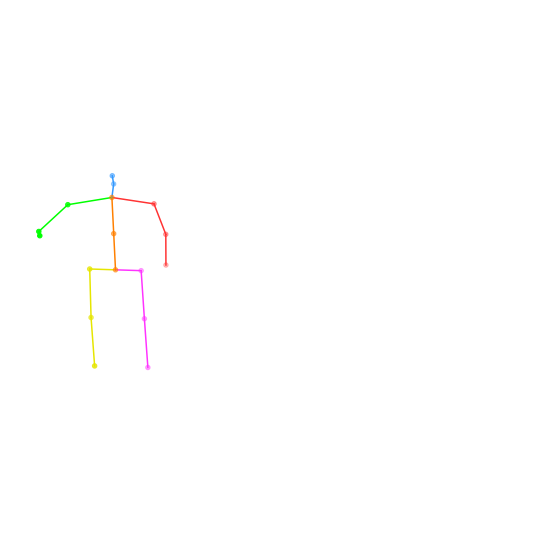

1


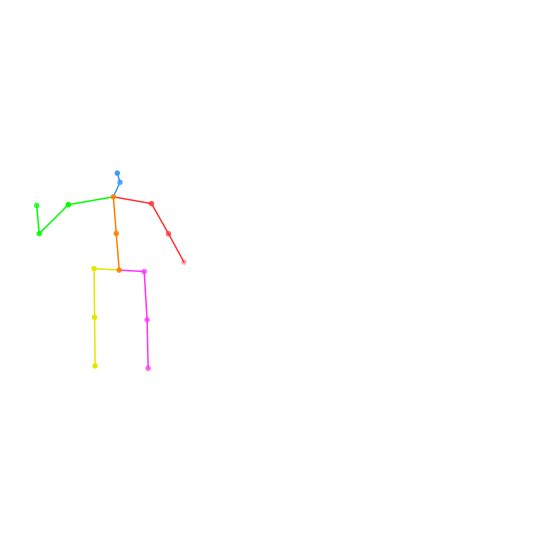

2


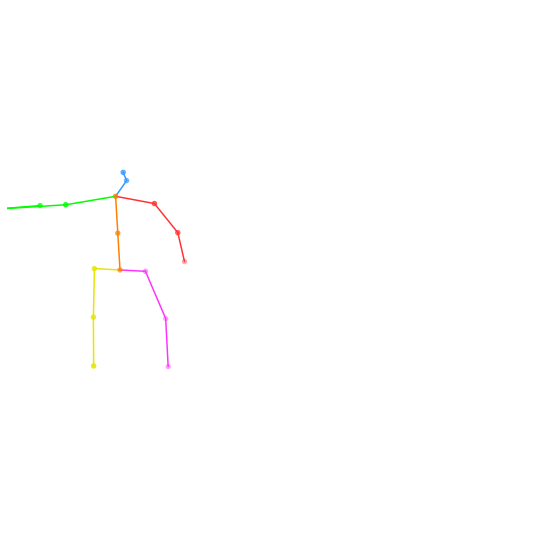

3


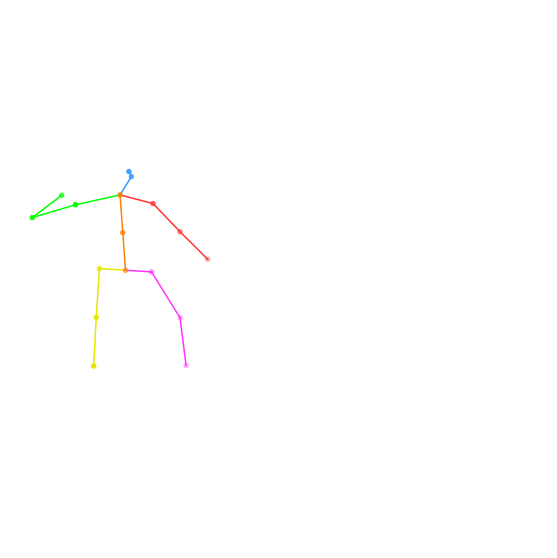

4


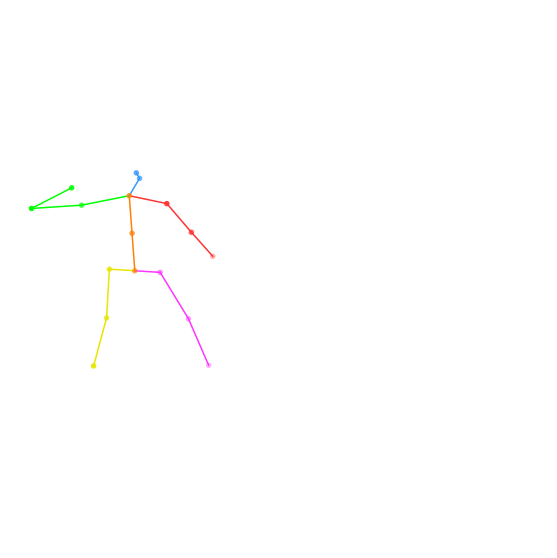

5


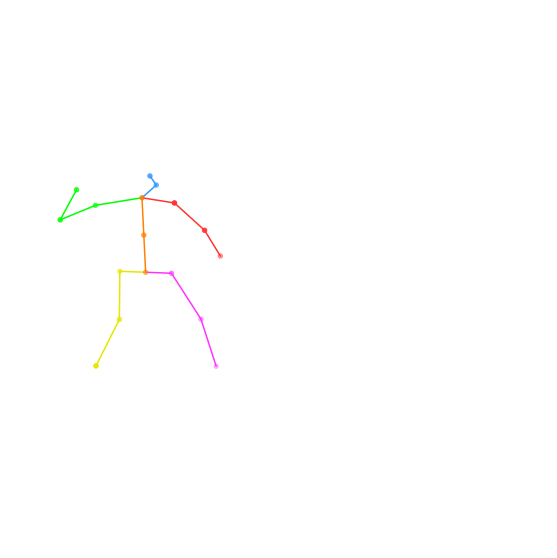

6


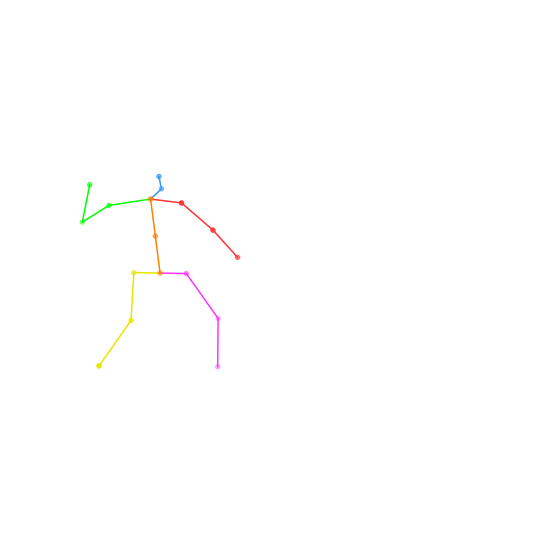

7


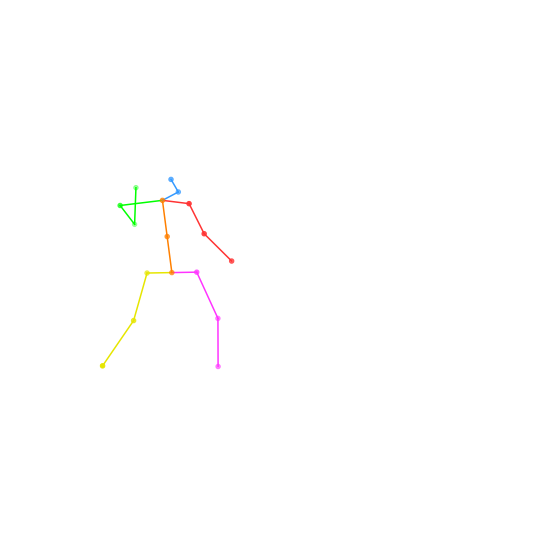

8


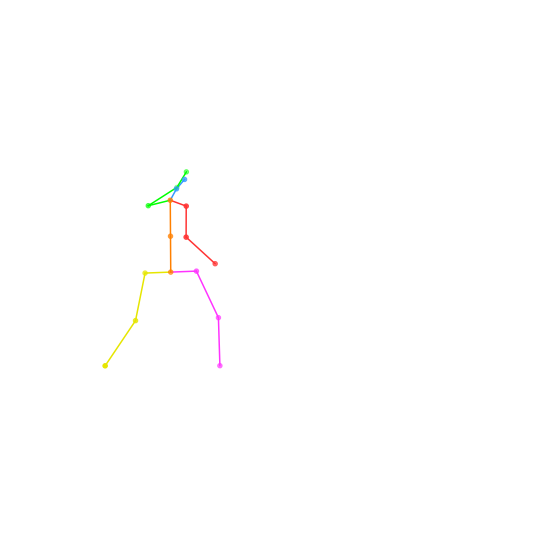

9


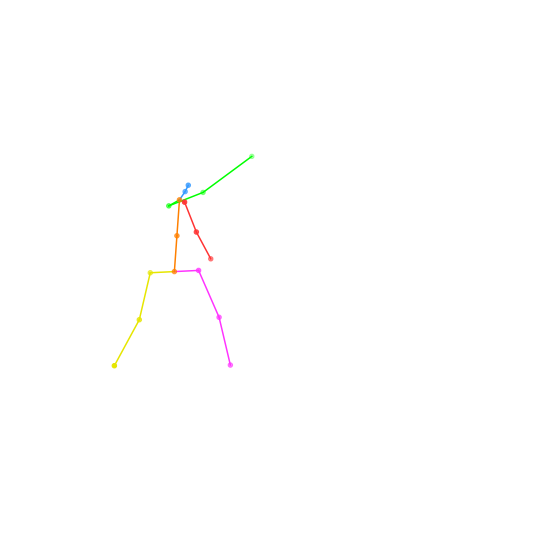

10


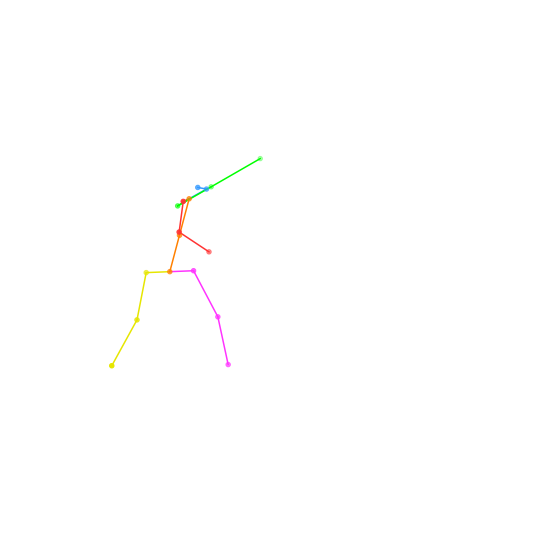

11


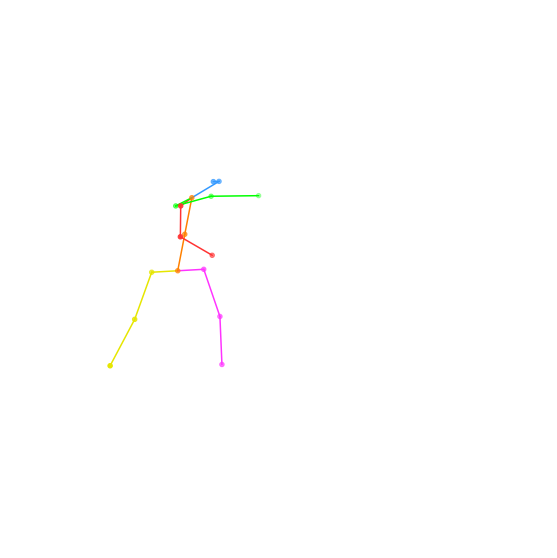

12


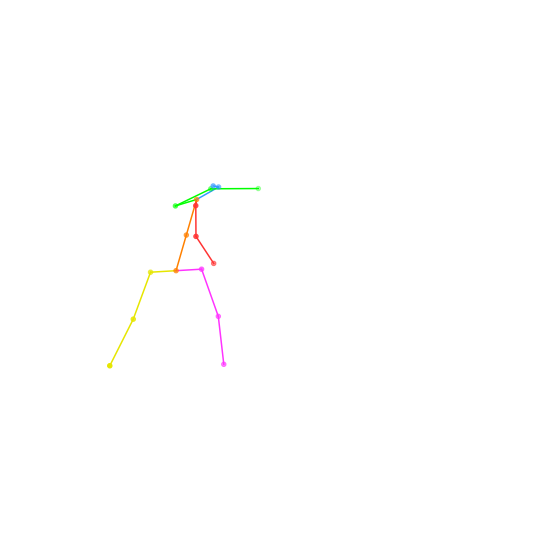

13


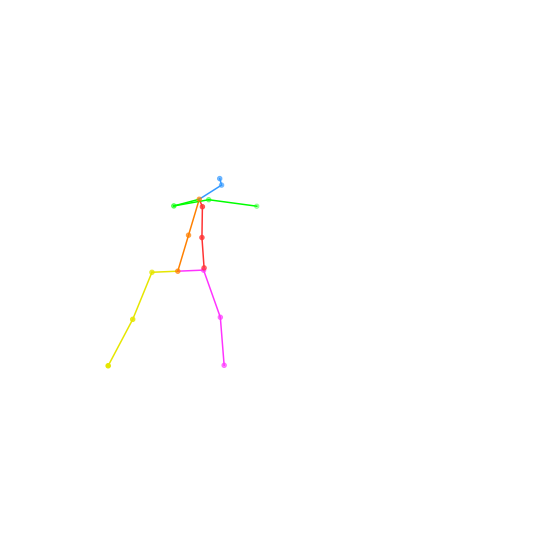

14


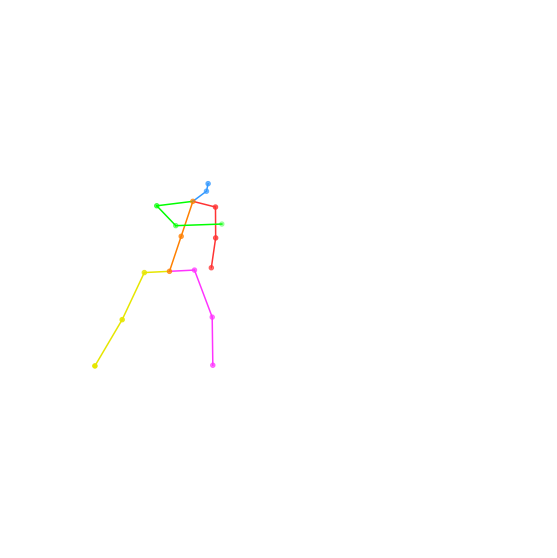

15


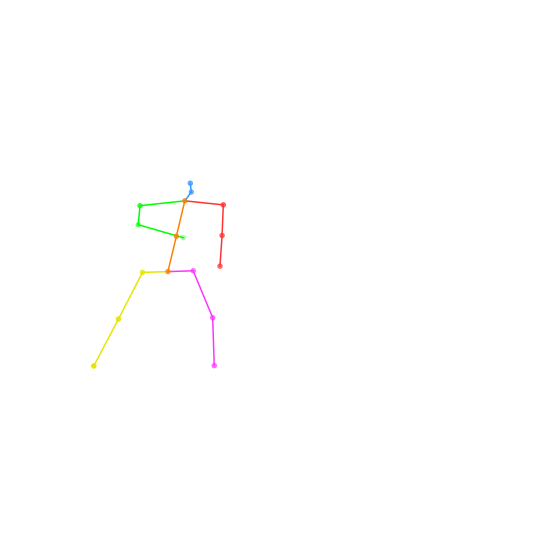

16


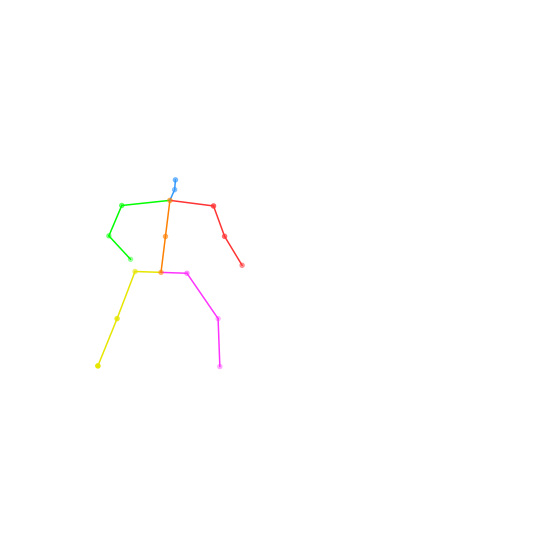

17


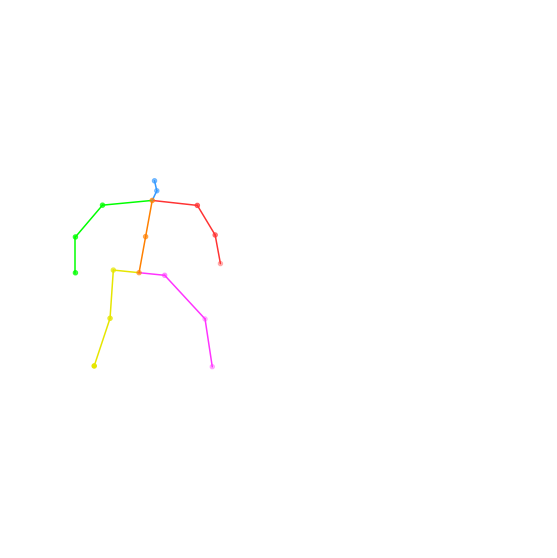

18


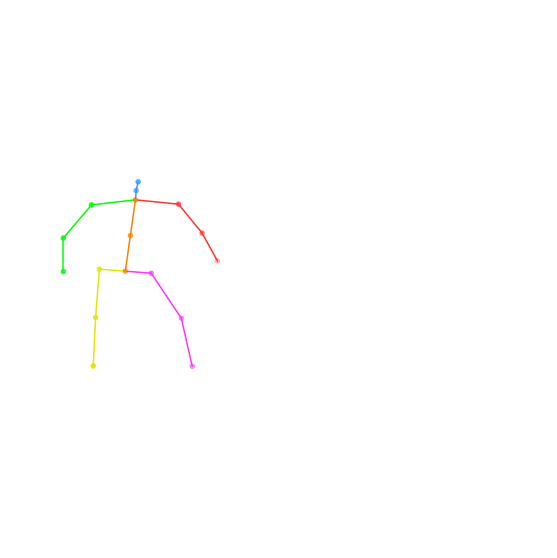

19


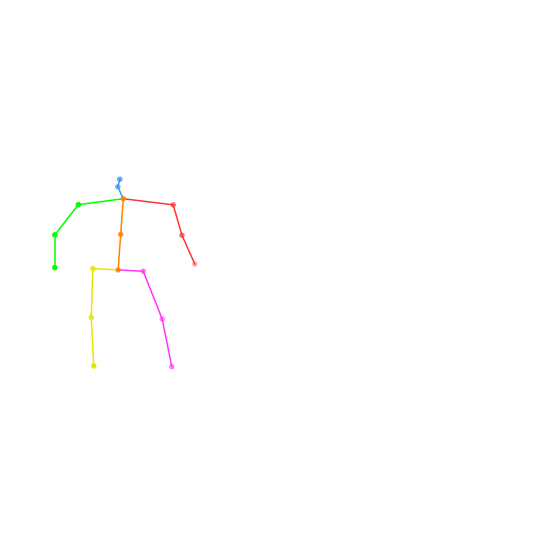

20


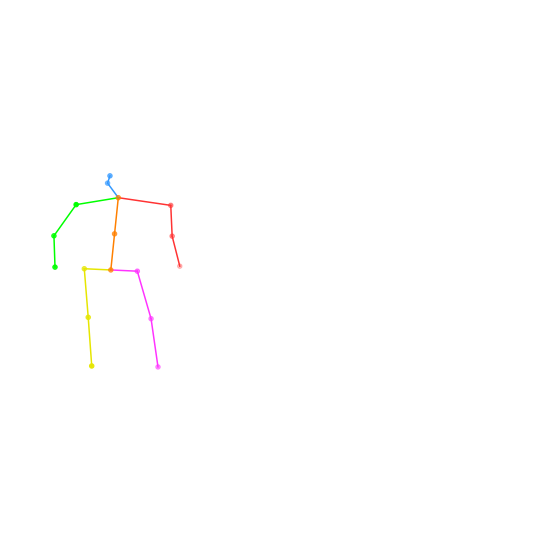

21


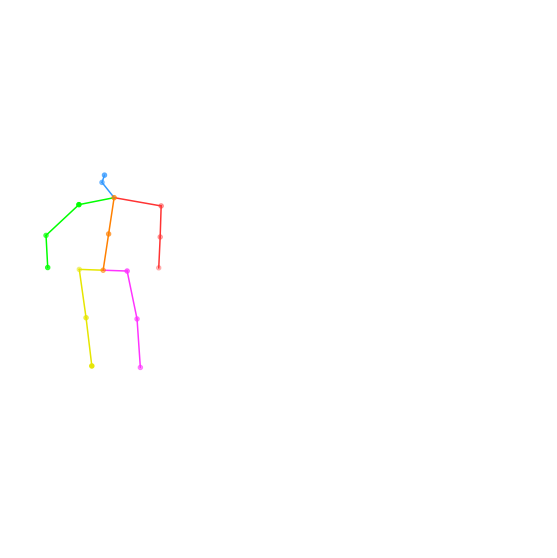

22


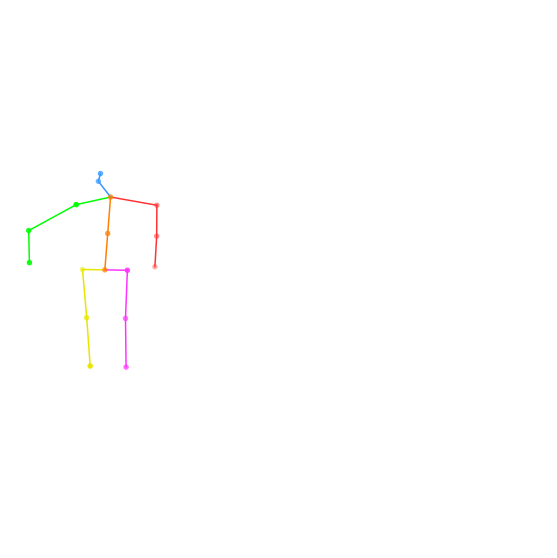

23


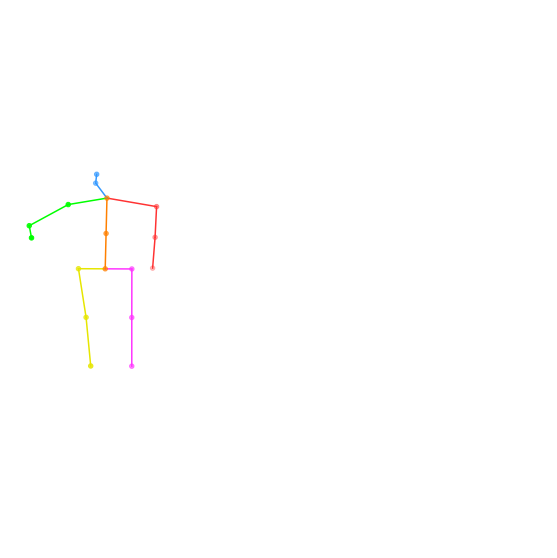

24


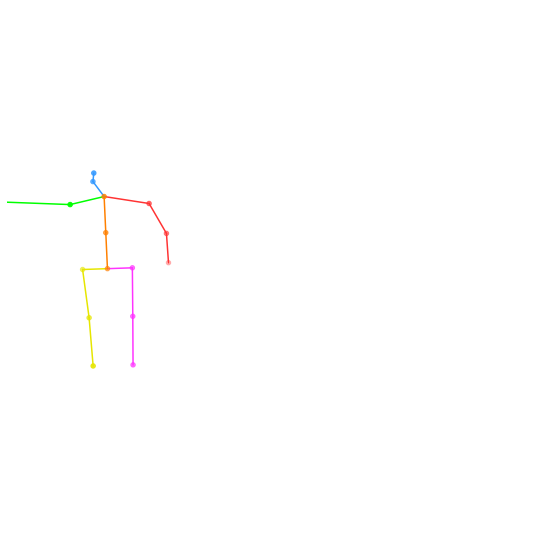

25


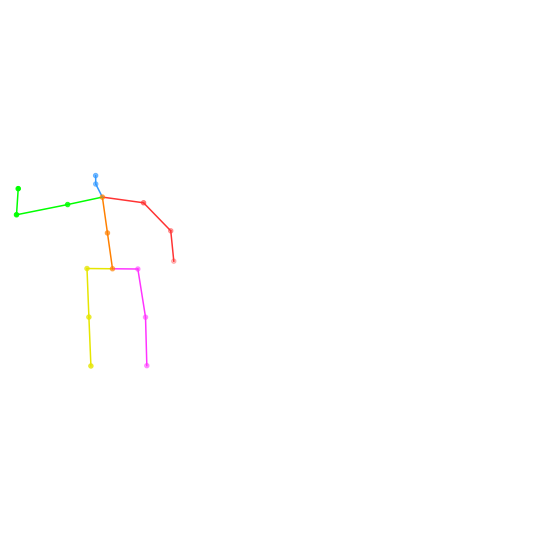

26


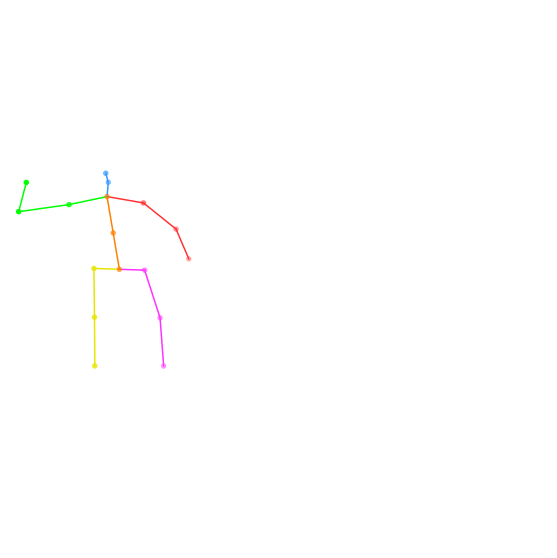

27


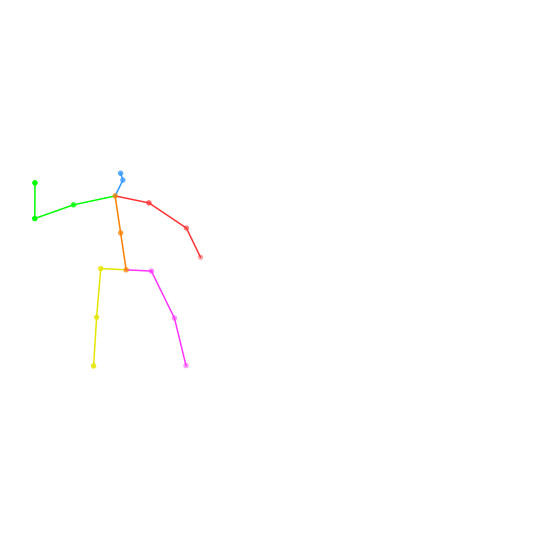

28


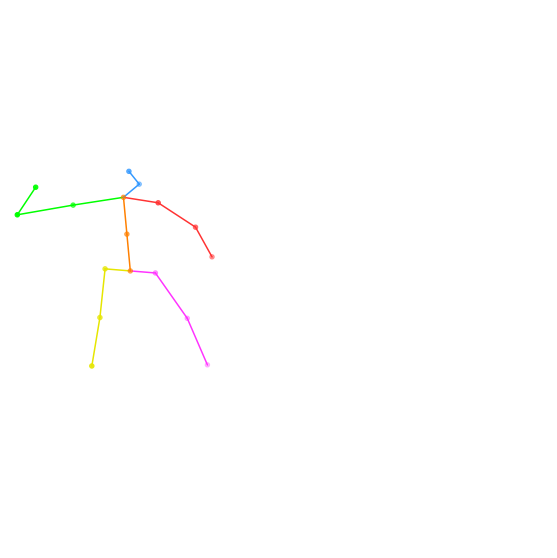

29


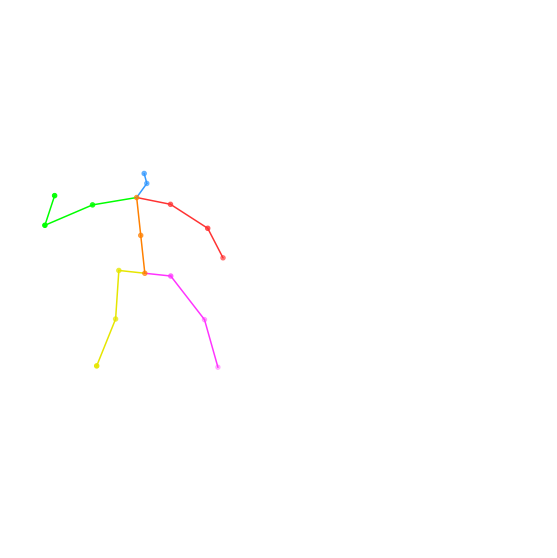

30


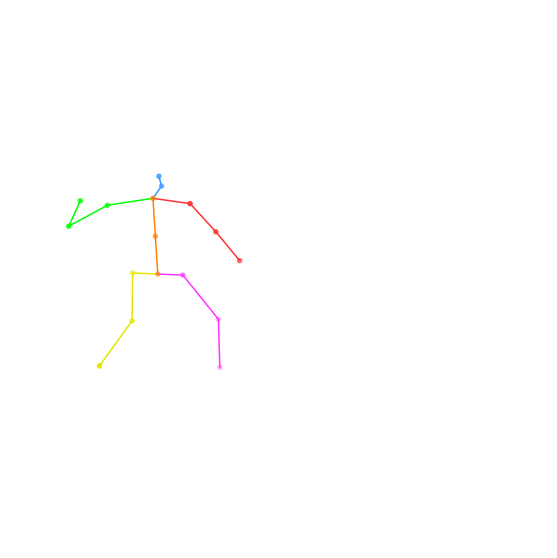

31


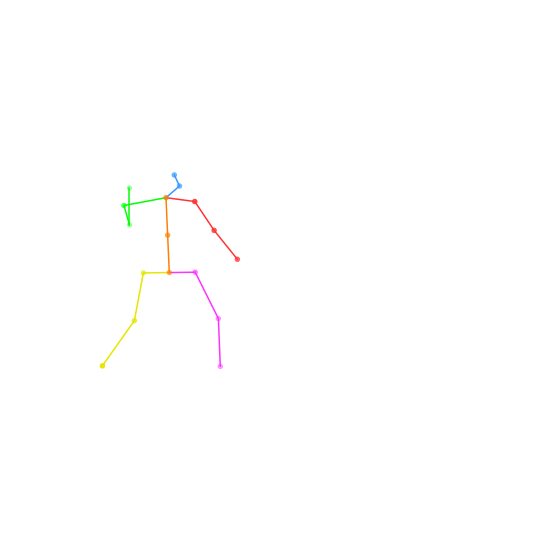

32


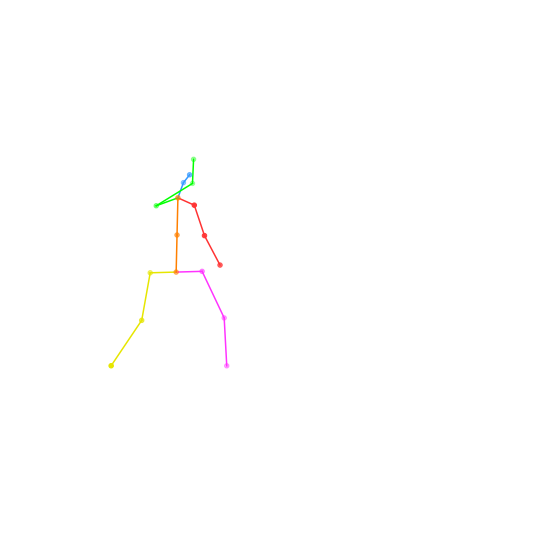

33


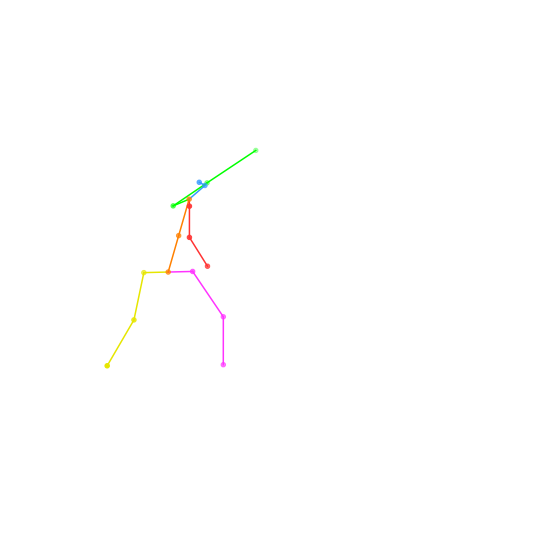

34


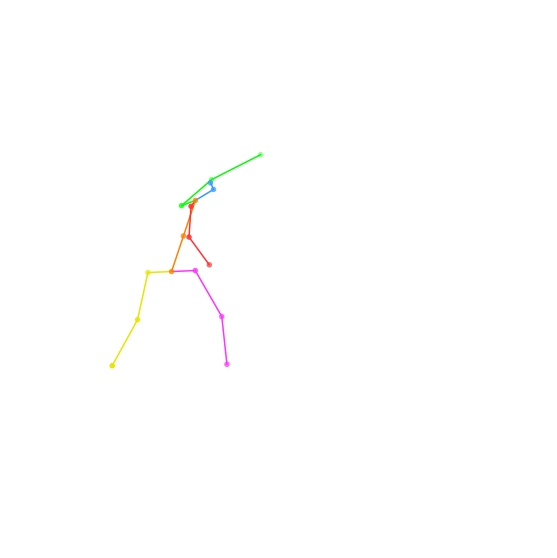

35


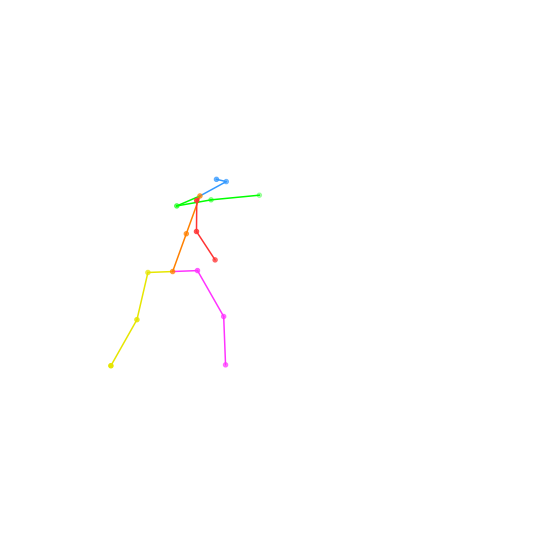

36


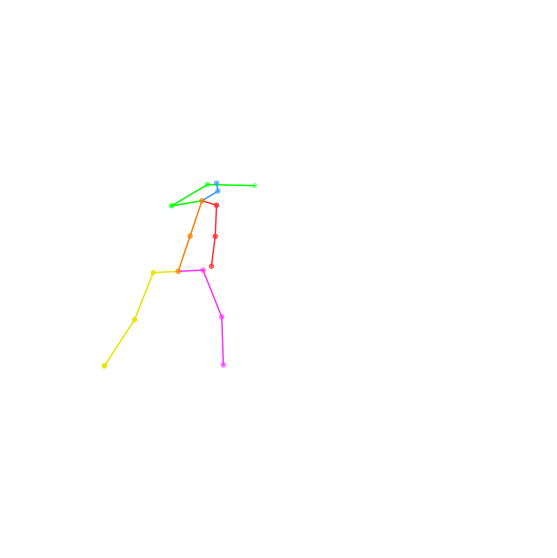

37


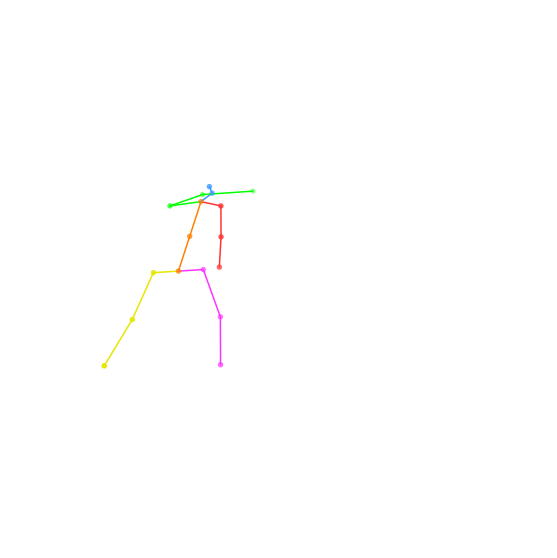

38


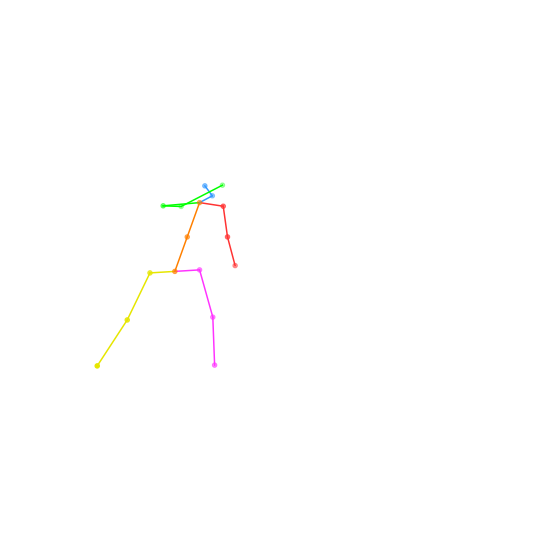

39


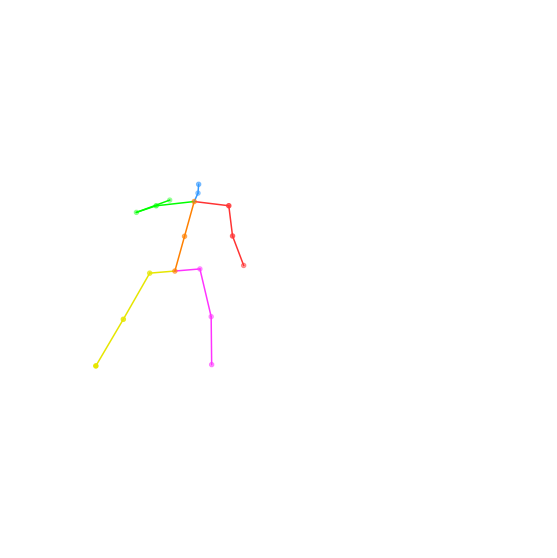

40


In [11]:
gt_numpy = np.load(gt_dir)
for i in range(len(gt_numpy)):
    print(i)
    if i == 40:
        break
    gt_ = gt_numpy[i].reshape(1,17,3)
    ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
    ax.set_xlim3d([0, 1.3])
    ax.set_zlim3d([0, 2])
    ax.set_ylim3d([0, 1.5])
    ax.view_init(elev=-0, azim =70)
    idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
    # for id in idx:
    ax.scatter(1-gt_[0,:,0], gt_[0,:,2]-3, 1-gt_[0,:,1], marker = 'o',c = pose_kpt_color[:])
    for i, line in enumerate(skeleton):
        start_idx = line[0]
        end_idx = line[1]
        ax.plot([1-gt_[0][start_idx][0], 1-gt_[0][end_idx][0]],[gt_[0][start_idx][2]-3,gt_[0][end_idx][2]-3],zs=[1-gt_[0][start_idx][1],1-gt_[0][end_idx][1]],c = (pose_kpt_color[end_idx][0],pose_kpt_color[end_idx][1],pose_kpt_color[end_idx][2]))
    plt.axis('off')
    plt.show()
    

## draw

In [89]:
outputs = outputs.cpu().detach().numpy()
gt_ = gt.unsqueeze(dim=0).cpu().detach().numpy()
# print(outputs.shape)
# gt_numpy = np.load(gt_dir)
# print(gt_numpy.shape)
# outputs = gt_numpy

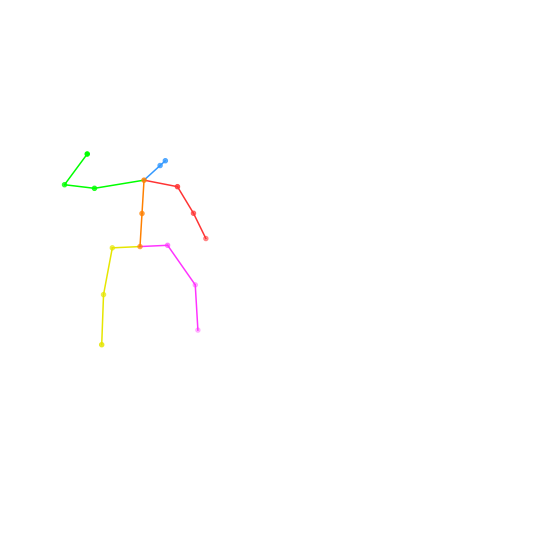

In [90]:
# print(outputs.shape)
# print(pose_kpt_color[id][0])
# for i in range(len(gt_numpy)):
    # print(i)
    # outputs = gt_numpy[i].reshape(1,17,3)
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.set_xlim3d([0, 1.3])
ax.set_zlim3d([0, 2])
ax.set_ylim3d([0, 1.5])
ax.view_init(elev=15, azim = 60)
idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
# for id in idx:
ax.scatter(1-gt_[0,:,0], gt_[0,:,2]-3, 1-gt_[0,:,1], marker = 'o',c = pose_kpt_color[:])
for i, line in enumerate(skeleton):
    start_idx = line[0]
    end_idx = line[1]
    ax.plot([1-gt_[0][start_idx][0], 1-gt_[0][end_idx][0]],[gt_[0][start_idx][2]-3,gt_[0][end_idx][2]-3],zs=[1-gt_[0][start_idx][1],1-gt_[0][end_idx][1]],c = (pose_kpt_color[end_idx][0],pose_kpt_color[end_idx][1],pose_kpt_color[end_idx][2]))
plt.axis('off')
plt.show()

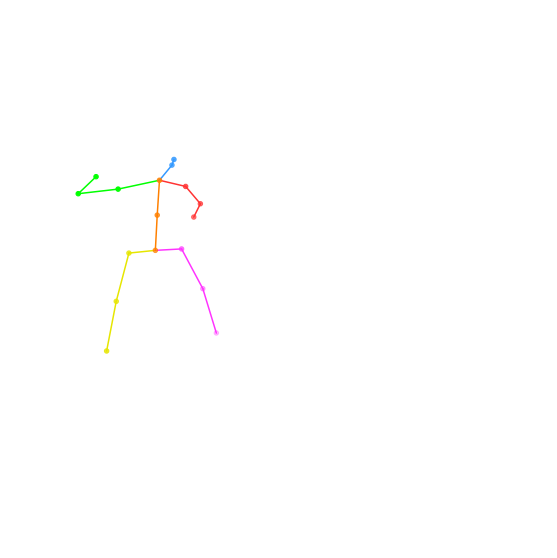

In [91]:
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.set_xlim3d([0, 1.3])
ax.set_zlim3d([0, 2])
ax.set_ylim3d([0, 1.5])
ax.view_init(elev=15, azim = 60)
idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
# for id in idx:
ax.scatter(1-outputs[0,:,0], outputs[0,:,2]-3, 1-outputs[0,:,1], marker = 'o',c = pose_kpt_color[:])
for i, line in enumerate(skeleton):
    start_idx = line[0]
    
    end_idx = line[1]
    ax.plot([1-outputs[0][start_idx][0], 1-outputs[0][end_idx][0]],[outputs[0][start_idx][2]-3,outputs[0][end_idx][2]-3],zs=[1-outputs[0][start_idx][1],1-outputs[0][end_idx][1]],c = (pose_kpt_color[end_idx][0],pose_kpt_color[end_idx][1],pose_kpt_color[end_idx][2]))
plt.axis('off')
plt.show()

# plot from np file

In [2]:
outputs = outputs = np.load('/Users/i590389/Desktop/papers/modality invariant/self_paper/pics/E01_S03_A20_frame275_all.npy')
# outputs = outputs.reshape(17,3)
# outputs = torch.FloatTensor(outputs)
# fake_score = torch.ones(1,17,1)
# print(outputs.shape)
# print(fake_score.shape)
# pred_keypoint_add = torch.cat([outputs , fake_score],dim=2).squeeze()
# pred_keypoint_add = pred_keypoint_add.cpu().detach().numpy()

In [103]:
# skeleton = [[15, 13], [13, 11], [16, 14], [14, 12], [11, 12],
#      [5, 11], [6, 12], [5, 6], [5, 7], [6, 8], [7, 9],
#       [8, 10], [1, 2], [0, 1], [0, 2], [1, 3], [2, 4],
#       [3, 5], [4, 6]]

# palette = np.array([[255, 128, 0], [255, 153, 51], [255, 178, 102],
#               [230, 230, 0], [255, 153, 255], [153, 204, 255],
#               [255, 102, 255], [255, 51, 255], [102, 178, 255],
#               [51, 153, 255], [255, 153, 153], [255, 102, 102],
#               [255, 51, 51], [153, 255, 153], [102, 255, 102],
#               [51, 255, 51], [0, 255, 0], [0, 0, 255],
#               [255, 0, 0], [255, 255, 255]])

# pose_link_color = palette[[
#   0, 0, 0, 0, 7, 7, 7, 9, 9, 9, 9, 9, 16, 16, 16, 16, 16, 16, 16
# ]]
# pose_kpt_color = palette[[
#   16, 16, 16, 16, 16, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0
# ]]
# kpt_score_thr = 0.3 # 阈值
# radius = 7
# thickness = 4

# fake_score = torch.ones(1,17,1)
# print(outputs.shape)
# print(fake_score.shape)
# pred_keypoint_add = torch.cat([outputs , fake_score],dim=2)
# pred_keypoint_add = pred_keypoint_add.cpu().detach().numpy()
# print(pred_keypoint_add.shape)

torch.Size([1, 17, 3])
torch.Size([1, 17, 1])
(1, 17, 4)


0.42345047 0.09794577 3.1088786
0.3221231 0.11076201 3.1079705
0.17489035 0.4565796 3.1230369
0.008688383 0.7877083 3.1393943
0.52453285 0.09876714 3.1010284
0.6267343 0.43508542 3.0662415
0.5924064 0.80438215 3.1459482
0.45798463 -0.18374012 3.1047819
0.49410436 -0.46195114 3.0983057
0.5743384 -0.5520871 3.0805125
0.5713705 -0.607636 3.1036246
0.5615764 -0.39320216 3.1520185
0.6864324 -0.25440782 3.1374972
0.7382594 -0.106514424 3.1045945
0.35110098 -0.43764538 3.0610552
0.347402 -0.5289452 3.027978
0.40978694 -0.602681 3.0211306


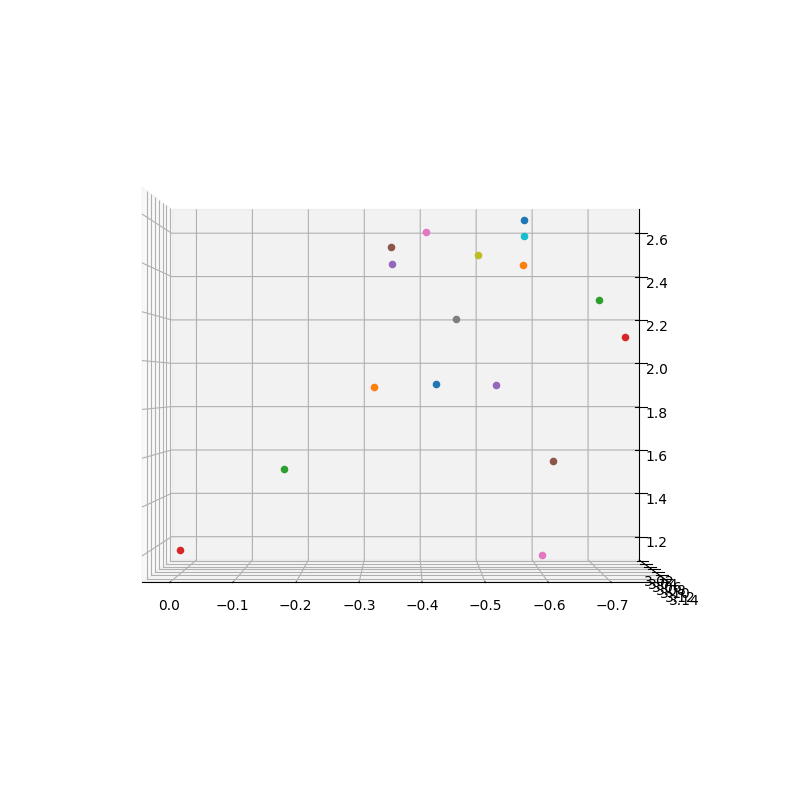

In [104]:
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
# for line in skeleton:
#   x = [pred_keypoint_add[0][line[0]][0], pred_keypoint_add[0][line[1]][0]]
#   y = [pred_keypoint_add[0][line[0]][1], pred_keypoint_add[0][line[1]][1]]
#   z = [pred_keypoint_add[0][line[0]][2], pred_keypoint_add[0][line[1]][2]]
#   ax.plot(x, y, z)
# #   break
ax.view_init(elev=0, azim = 90)
# for i in range(17):
#   ax.scatter(0-pred_keypoint_add[0][i][0], 0-pred_keypoint_add[0][i][1], 0-pred_keypoint_add[0][i][2])
#   # break
# ax.view_init(elev=-90, azim = 90)
for i in range(17):
  print(pred_keypoint_add[0][i][0], pred_keypoint_add[0][i][1],pred_keypoint_add[0][i][2])
  ax.scatter(0-pred_keypoint_add[0][i][0], pred_keypoint_add[0][i][2], 2-pred_keypoint_add[0][i][1])
  # ax.scatter(pred_keypoint_add[0][i][2], pred_keypoint_add[0][i][0],0-pred_keypoint_add[0][i][1])
  # break
plt.show()

0.42345047 0.09794577 3.1088786
0.3221231 0.11076201 3.1079705
0.17489035 0.4565796 3.1230369
0.008688383 0.7877083 3.1393943
0.52453285 0.09876714 3.1010284
0.6267343 0.43508542 3.0662415
0.5924064 0.80438215 3.1459482
0.45798463 -0.18374012 3.1047819
0.49410436 -0.46195114 3.0983057
0.5743384 -0.5520871 3.0805125
0.5713705 -0.607636 3.1036246
0.5615764 -0.39320216 3.1520185
0.6864324 -0.25440782 3.1374972
0.7382594 -0.106514424 3.1045945
0.35110098 -0.43764538 3.0610552
0.347402 -0.5289452 3.027978
0.40978694 -0.602681 3.0211306


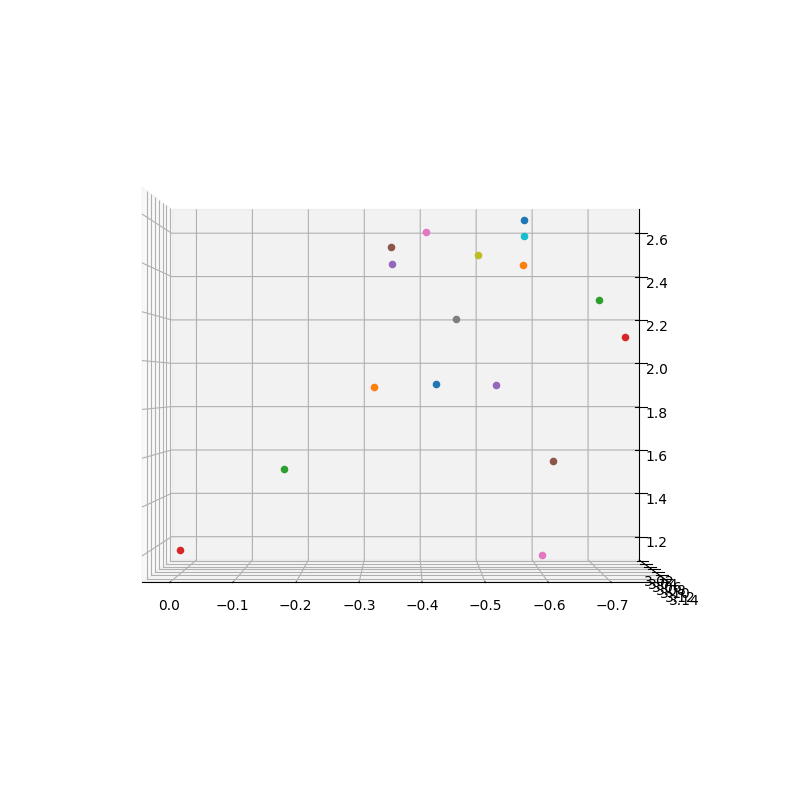

In [134]:
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
# for line in skeleton:
#   x = [pred_keypoint_add[0][line[0]][0], pred_keypoint_add[0][line[1]][0]]
#   y = [pred_keypoint_add[0][line[0]][1], pred_keypoint_add[0][line[1]][1]]
#   z = [pred_keypoint_add[0][line[0]][2], pred_keypoint_add[0][line[1]][2]]
#   ax.plot(x, y, z)
# #   break
ax.view_init(elev=0, azim = 90)
# for i in range(17):
#   ax.scatter(0-pred_keypoint_add[0][i][0], 0-pred_keypoint_add[0][i][1], 0-pred_keypoint_add[0][i][2])
#   # break
# ax.view_init(elev=-90, azim = 90)
for i in range(17):
  print(pred_keypoint_add[0][i][0], pred_keypoint_add[0][i][1],pred_keypoint_add[0][i][2])
  ax.scatter(0-outputs[0][i][0], outputs[0][i][2], 2-outputs[0][i][1])
  # ax.scatter(pred_keypoint_add[0][i][2], pred_keypoint_add[0][i][0],0-pred_keypoint_add[0][i][1])
  # break
plt.show()

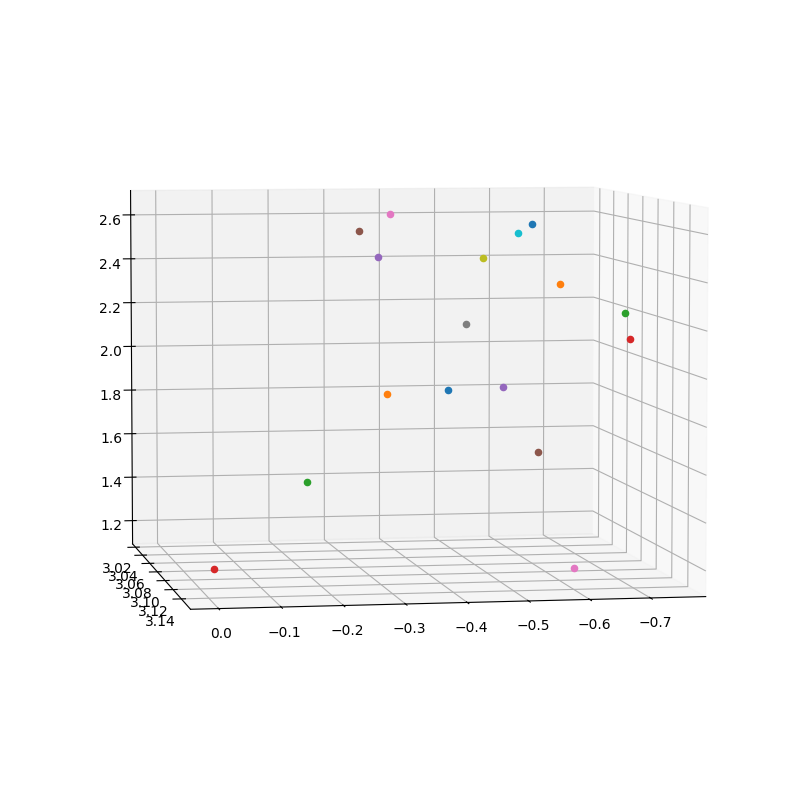

In [160]:
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.view_init(elev=5, azim = 80)
idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
for id in idx:
    ax.scatter(0-outputs[0][id][0], outputs[0][id][2], 2-outputs[0][id][1])
plt.show()

In [10]:
skeleton = [[0, 1], [0, 4], [0, 7], [7, 8],[8, 11],[8, 14], 
            # [11,7],[14,7], 
            [1, 2], [2, 3], 
            [4, 5],[5, 6],
            [8, 9], [9,10], 
            [11, 12], [12, 13],
            [14, 15], [15, 16]]
palette = np.array([[255, 128, 0], [255, 153, 51], [255, 178, 102],
              [230, 230, 0], [255, 153, 255], [153, 204, 255],
              [255, 102, 255], [255, 51, 255], [102, 178, 255],
              [51, 153, 255], [255, 153, 153], [255, 102, 102],
              [255, 51, 51], [153, 255, 153], [102, 255, 102],
              [51, 255, 51],[0, 0, 255],[255,215,0]])
# palette = ['#FFCE9F','#B3D1FF','#95ADD4','#7E94B5','#BAE0ED','#ACCFDB','#FFE2C2','#FFB570','#FFE599','#FFF34F',
#            '#DBEDB3','#CDED8C','#BBED58','#A6FFF3','#78FFF1','#1FFFE9']

pose_link_color = palette[[
  9,14,13,15,11,10,12,16,8,3,17,7,4,6,1,2,0
]]/255.
pose_kpt_color = palette[[
  9,14,13,15,11,10,12,16,8,3,17,7,4,6,1,2,0
]]/255.


In [11]:
_color = pose_kpt_color[..., ::-1]
print(_color)


[[1.         0.6        0.2       ]
 [0.4        1.         0.4       ]
 [0.6        1.         0.6       ]
 [0.2        1.         0.2       ]
 [0.4        0.4        1.        ]
 [0.6        0.6        1.        ]
 [0.2        0.2        1.        ]
 [1.         0.         0.        ]
 [1.         0.69803922 0.4       ]
 [0.         0.90196078 0.90196078]
 [0.         0.84313725 1.        ]
 [1.         0.2        1.        ]
 [1.         0.6        1.        ]
 [1.         0.4        1.        ]
 [0.2        0.6        1.        ]
 [0.4        0.69803922 1.        ]
 [0.         0.50196078 1.        ]]


(1, 17, 3)


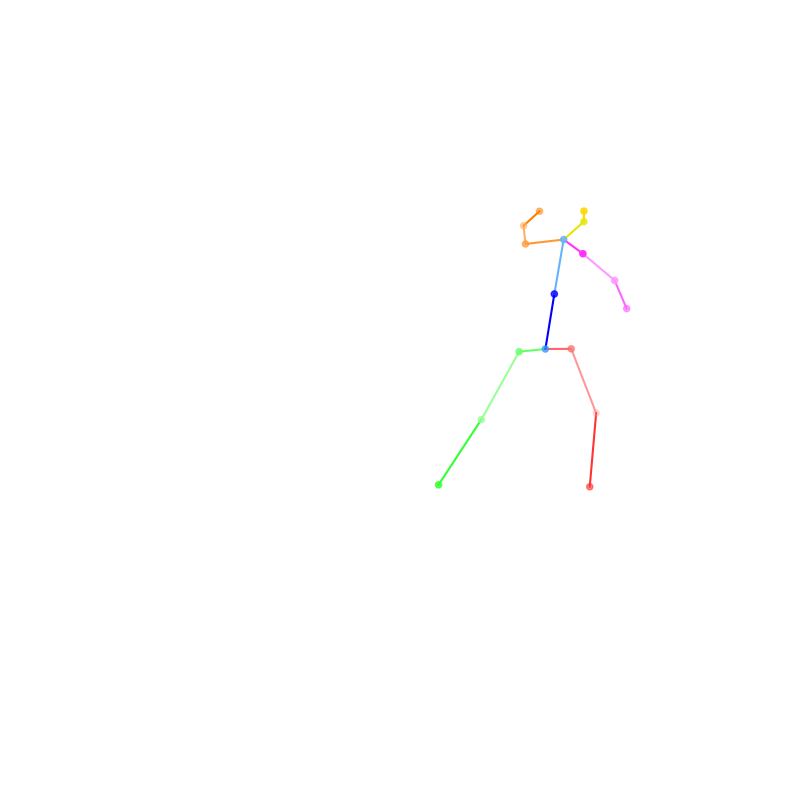

In [16]:
axis_azimuth=70,
axis_limit=1.7
axis_dist=10.0
axis_elev=15.0

outputs = np.load('/Users/i590389/Desktop/papers/modality invariant/self_paper/pics/E01_S03_A20_frame275_all.npy')
print(outputs.shape)
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
# ax.set_xlim3d([0, 1.3])
# ax.set_zlim3d([0, 2])
# ax.set_ylim3d([0, 1.5])
ax.view_init(
            elev=axis_elev,
            azim=axis_azimuth,
        )
x_c = np.mean(outputs[:, 0])
y_c = np.mean(outputs[:, 1])

ax.set_xlim3d([x_c - axis_limit / 2, x_c + axis_limit / 2])
ax.set_ylim3d([y_c - axis_limit / 2, y_c + axis_limit / 2])
ax.set_zlim3d([0, axis_limit])
ax.set_aspect('auto')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.dist = axis_dist
ax.view_init(elev=5, azim = 85)
idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
# for id in idx:
ax.scatter(1-outputs[0,:,0],
           outputs[0,:,2]-3,
           1-outputs[0,:,1],
           marker='o',
        #    c = (pose_kpt_color[id][0],pose_kpt_color[id][1],pose_kpt_color[id][2]))
            c = pose_kpt_color[:])
for i, line in enumerate(skeleton):
    start_idx = line[0]
    end_idx = line[1]
    ax.plot([1-outputs[0][start_idx][0], 1-outputs[0][end_idx][0]],[outputs[0][start_idx][2]-3,outputs[0][end_idx][2]-3],zs=[1-outputs[0][start_idx][1],1-outputs[0][end_idx][1]],c = (pose_kpt_color[end_idx][0],pose_kpt_color[end_idx][1],pose_kpt_color[end_idx][2]))
plt.axis('off')
plt.show()

# Single modality result

In [324]:
outputs = np.load('/Users/i590389/Desktop/papers/modality invariant/self_paper/pics/E01_S03_A20_frame275_rgb.npy')


/var/folders/zy/5ffpky1j2j31qd6wrlpb02bc0000gn/T/ipykernel_27926/911385289.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(1-outputs[0][id][0], outputs[0][id][2]-3, 1-outputs[0][id][1], c = (pose_kpt_color[id][0],pose_kpt_color[id][1],pose_kpt_color[id][2]))


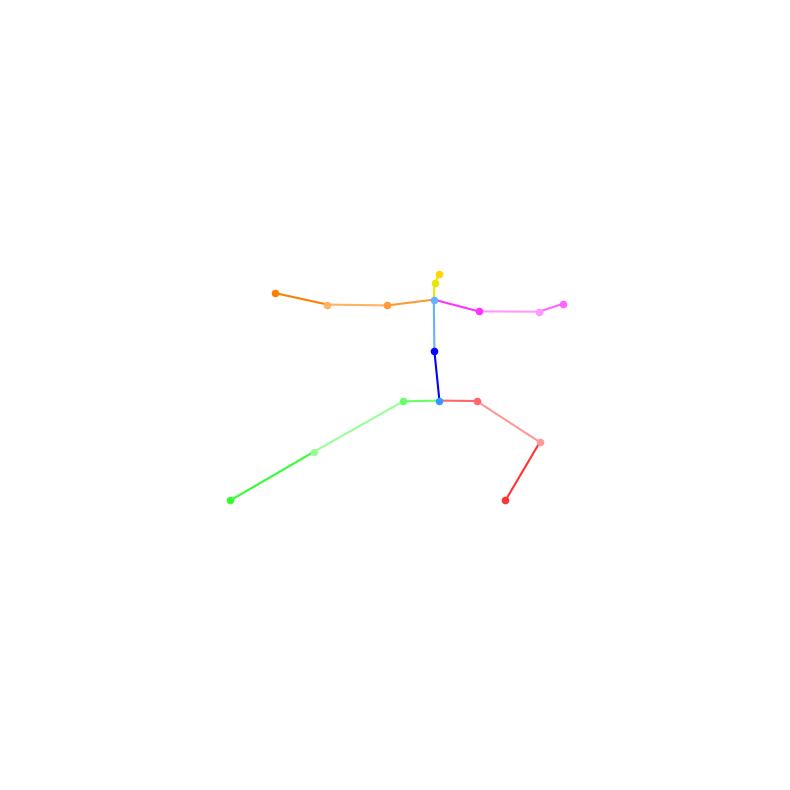

In [325]:
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.set_xlim3d([0, 1.3])
ax.set_zlim3d([0, 2])
ax.set_ylim3d([0, 1.5])
ax.view_init(elev=5, azim = 85)
idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
for id in idx:
    ax.scatter(1-outputs[0][id][0], outputs[0][id][2]-3, 1-outputs[0][id][1], c = (pose_kpt_color[id][0],pose_kpt_color[id][1],pose_kpt_color[id][2]))
for i, line in enumerate(skeleton):
    start_idx = line[0]
    end_idx = line[1]
    ax.plot([1-outputs[0][start_idx][0], 1-outputs[0][end_idx][0]],[outputs[0][start_idx][2]-3,outputs[0][end_idx][2]-3],zs=[1-outputs[0][start_idx][1],1-outputs[0][end_idx][1]],c = (pose_kpt_color[end_idx][0],pose_kpt_color[end_idx][1],pose_kpt_color[end_idx][2]))
plt.axis('off')
plt.show()

In [326]:
outputs = np.load('/Users/i590389/Desktop/papers/modality invariant/self_paper/pics/E01_S03_A20_frame275_depth.npy')

/var/folders/zy/5ffpky1j2j31qd6wrlpb02bc0000gn/T/ipykernel_27926/369970215.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(1-outputs[0][id][0], outputs[0][id][2]-3, 1-outputs[0][id][1], c = (pose_kpt_color[id][0],pose_kpt_color[id][1],pose_kpt_color[id][2]))


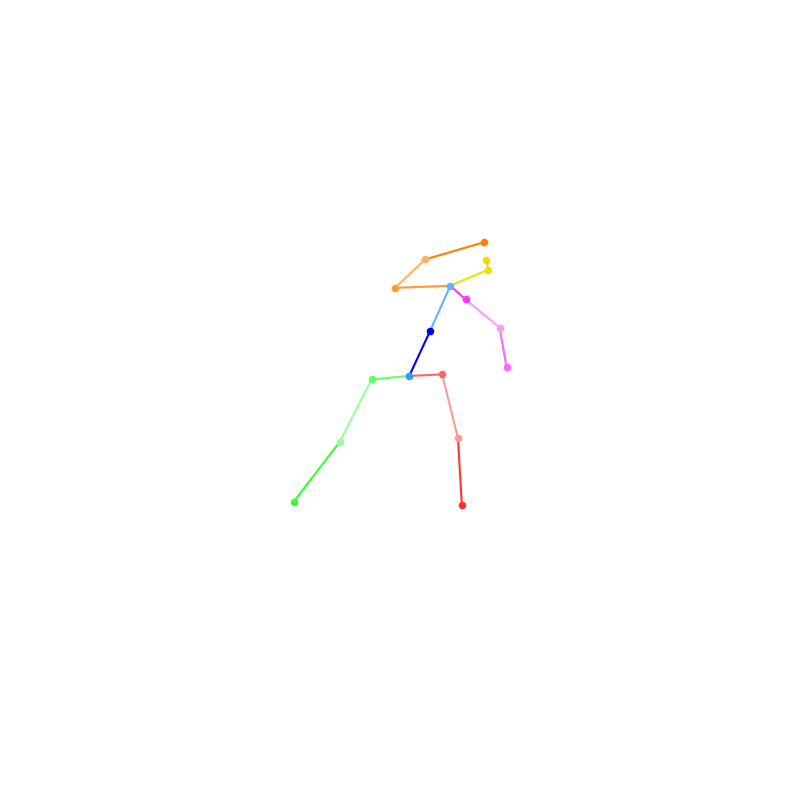

In [327]:
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.set_xlim3d([0, 1.3])
ax.set_zlim3d([0, 2])
ax.set_ylim3d([0, 1.5])
ax.view_init(elev=5, azim = 85)
idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
for id in idx:
    ax.scatter(1-outputs[0][id][0], outputs[0][id][2]-3, 1-outputs[0][id][1], c = (pose_kpt_color[id][0],pose_kpt_color[id][1],pose_kpt_color[id][2]))
for i, line in enumerate(skeleton):
    start_idx = line[0]
    end_idx = line[1]
    
    ax.plot([1-outputs[0][start_idx][0], 1-outputs[0][end_idx][0]],[outputs[0][start_idx][2]-3,outputs[0][end_idx][2]-3],zs=[1-outputs[0][start_idx][1],1-outputs[0][end_idx][1]],c = (pose_kpt_color[end_idx][0],pose_kpt_color[end_idx][1],pose_kpt_color[end_idx][2]))
plt.axis('off')
plt.show()

/var/folders/zy/5ffpky1j2j31qd6wrlpb02bc0000gn/T/ipykernel_27926/3683069803.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(1-outputs[0][id][0], outputs[0][id][2]-3, 1-outputs[0][id][1], c = (pose_kpt_color[id][0],pose_kpt_color[id][1],pose_kpt_color[id][2]))


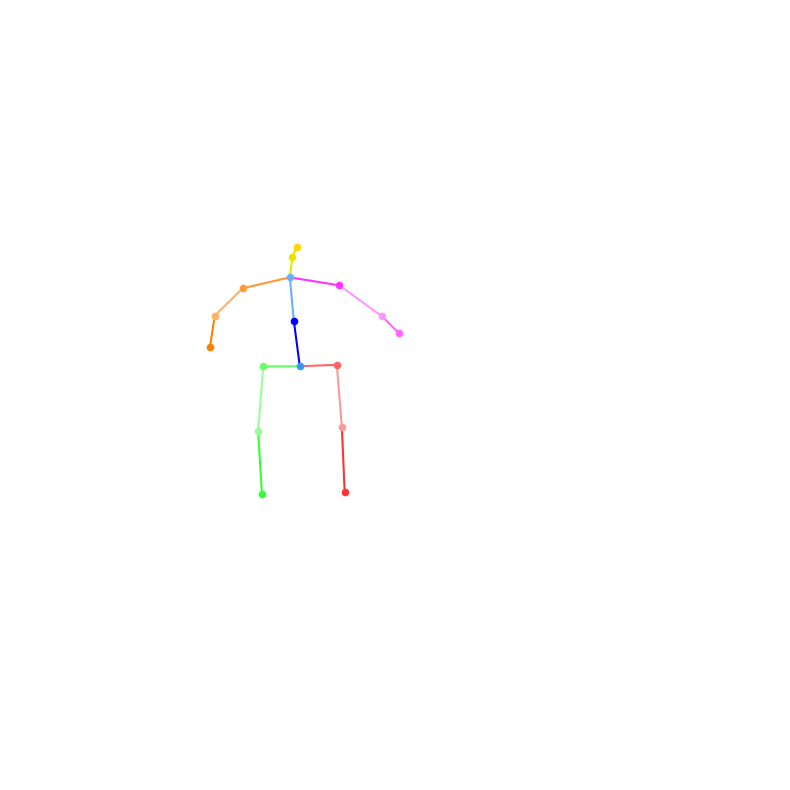

In [328]:
outputs = np.load('/Users/i590389/Desktop/papers/modality invariant/self_paper/pics/E01_S03_A20_frame275_mmwave.npy')
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.set_xlim3d([0, 1.3])
ax.set_zlim3d([0, 2])
ax.set_ylim3d([0, 1.5])
ax.view_init(elev=5, azim = 85)
idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
for id in idx:
    ax.scatter(1-outputs[0][id][0], outputs[0][id][2]-3, 1-outputs[0][id][1], c = (pose_kpt_color[id][0],pose_kpt_color[id][1],pose_kpt_color[id][2]))
for i, line in enumerate(skeleton):
    start_idx = line[0]
    end_idx = line[1]
    ax.plot([1-outputs[0][start_idx][0], 1-outputs[0][end_idx][0]],[outputs[0][start_idx][2]-3,outputs[0][end_idx][2]-3],zs=[1-outputs[0][start_idx][1],1-outputs[0][end_idx][1]],c = (pose_kpt_color[end_idx][0],pose_kpt_color[end_idx][1],pose_kpt_color[end_idx][2]))
plt.axis('off')
plt.show()


/var/folders/zy/5ffpky1j2j31qd6wrlpb02bc0000gn/T/ipykernel_27926/3425731563.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(1-outputs[0][id][0], outputs[0][id][2]-3, 1-outputs[0][id][1], c = (pose_kpt_color[id][0],pose_kpt_color[id][1],pose_kpt_color[id][2]))


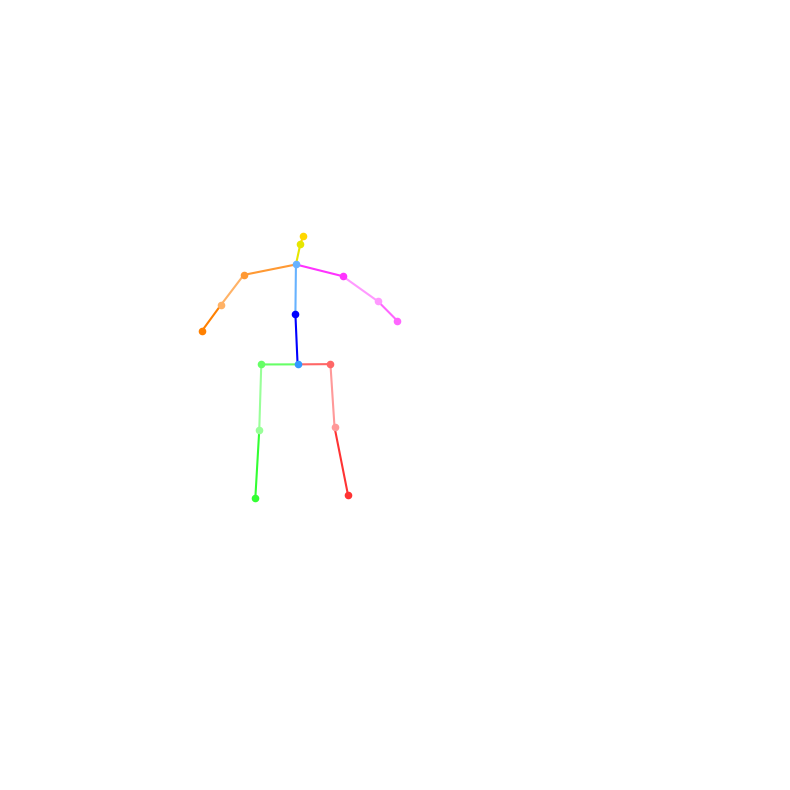

In [329]:
outputs = np.load('/Users/i590389/Desktop/papers/modality invariant/self_paper/pics/E01_S03_A20_frame275_lidar.npy')
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.set_xlim3d([0, 1.3])
ax.set_zlim3d([0, 2])
ax.set_ylim3d([0, 1.5])
ax.view_init(elev=5, azim = 85)
idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
for id in idx:
    ax.scatter(1-outputs[0][id][0], outputs[0][id][2]-3, 1-outputs[0][id][1], c = (pose_kpt_color[id][0],pose_kpt_color[id][1],pose_kpt_color[id][2]))
for i, line in enumerate(skeleton):
    start_idx = line[0]
    end_idx = line[1]
    ax.plot([1-outputs[0][start_idx][0], 1-outputs[0][end_idx][0]],[outputs[0][start_idx][2]-3,outputs[0][end_idx][2]-3],zs=[1-outputs[0][start_idx][1],1-outputs[0][end_idx][1]],c = (pose_kpt_color[end_idx][0],pose_kpt_color[end_idx][1],pose_kpt_color[end_idx][2]))
plt.axis('off')
plt.show()

/var/folders/zy/5ffpky1j2j31qd6wrlpb02bc0000gn/T/ipykernel_27926/2487258836.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(1-outputs[0][id][0], outputs[0][id][2]-3, 1-outputs[0][id][1], c = (pose_kpt_color[id][0],pose_kpt_color[id][1],pose_kpt_color[id][2]))


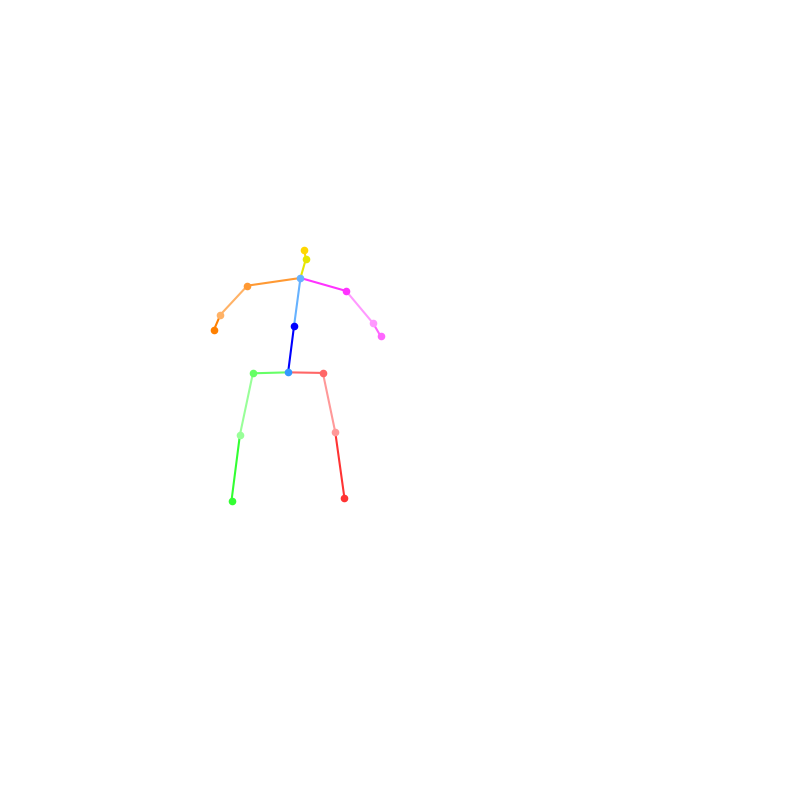

In [330]:
outputs = np.load('/Users/i590389/Desktop/papers/modality invariant/self_paper/pics/E01_S03_A20_frame275_wifi.npy')
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.set_xlim3d([0, 1.3])
ax.set_zlim3d([0, 2])
ax.set_ylim3d([0, 1.5])
ax.view_init(elev=5, azim = 85)
idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
for id in idx:
    ax.scatter(1-outputs[0][id][0], outputs[0][id][2]-3, 1-outputs[0][id][1], c = (pose_kpt_color[id][0],pose_kpt_color[id][1],pose_kpt_color[id][2]))
for i, line in enumerate(skeleton):
    start_idx = line[0]
    end_idx = line[1]
    ax.plot([1-outputs[0][start_idx][0], 1-outputs[0][end_idx][0]],[outputs[0][start_idx][2]-3,outputs[0][end_idx][2]-3],zs=[1-outputs[0][start_idx][1],1-outputs[0][end_idx][1]],c = (pose_kpt_color[end_idx][0],pose_kpt_color[end_idx][1],pose_kpt_color[end_idx][2]))
plt.axis('off')
plt.show()

# dual

/var/folders/zy/5ffpky1j2j31qd6wrlpb02bc0000gn/T/ipykernel_27926/134961275.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(1-outputs[0][id][0], outputs[0][id][2]-3, 1-outputs[0][id][1], c = (pose_kpt_color[id][0],pose_kpt_color[id][1],pose_kpt_color[id][2]))


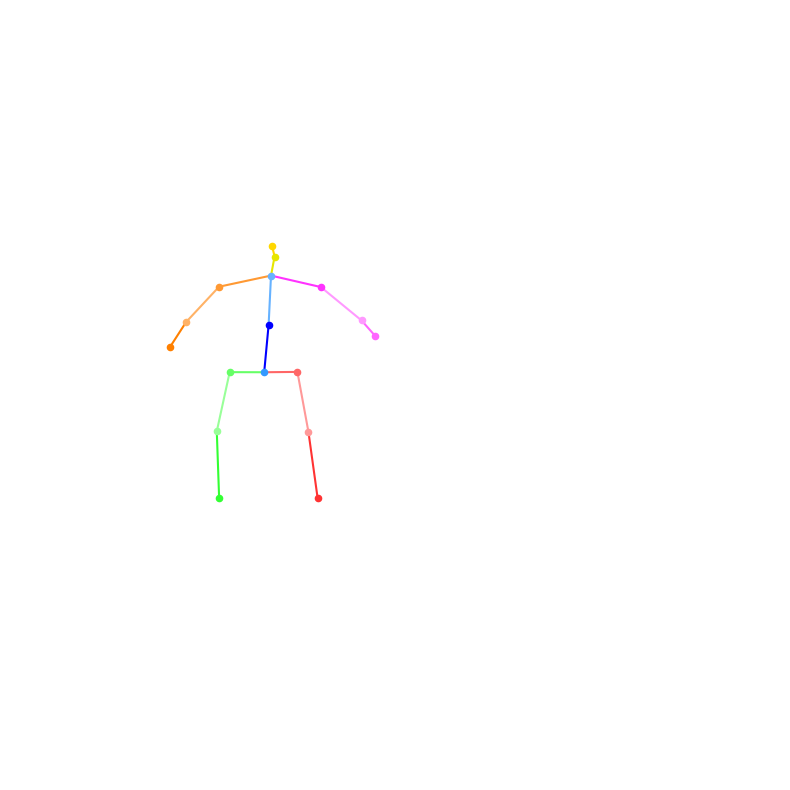

In [331]:
outputs = np.load('/Users/i590389/Desktop/papers/modality invariant/self_paper/pics/E01_S03_A20_frame275_LW.npy')
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.set_xlim3d([0, 1.3])
ax.set_zlim3d([0, 2])
ax.set_ylim3d([0, 1.5])
ax.view_init(elev=5, azim = 85)
idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
for id in idx:
    ax.scatter(1-outputs[0][id][0], outputs[0][id][2]-3, 1-outputs[0][id][1], c = (pose_kpt_color[id][0],pose_kpt_color[id][1],pose_kpt_color[id][2]))
for i, line in enumerate(skeleton):
    start_idx = line[0]
    end_idx = line[1]
    ax.plot([1-outputs[0][start_idx][0], 1-outputs[0][end_idx][0]],[outputs[0][start_idx][2]-3,outputs[0][end_idx][2]-3],zs=[1-outputs[0][start_idx][1],1-outputs[0][end_idx][1]],c = (pose_kpt_color[end_idx][0],pose_kpt_color[end_idx][1],pose_kpt_color[end_idx][2]))
plt.axis('off')
plt.show()

/var/folders/zy/5ffpky1j2j31qd6wrlpb02bc0000gn/T/ipykernel_27926/2103496250.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(1-outputs[0][id][0], outputs[0][id][2]-3, 1-outputs[0][id][1], c = (pose_kpt_color[id][0],pose_kpt_color[id][1],pose_kpt_color[id][2]))


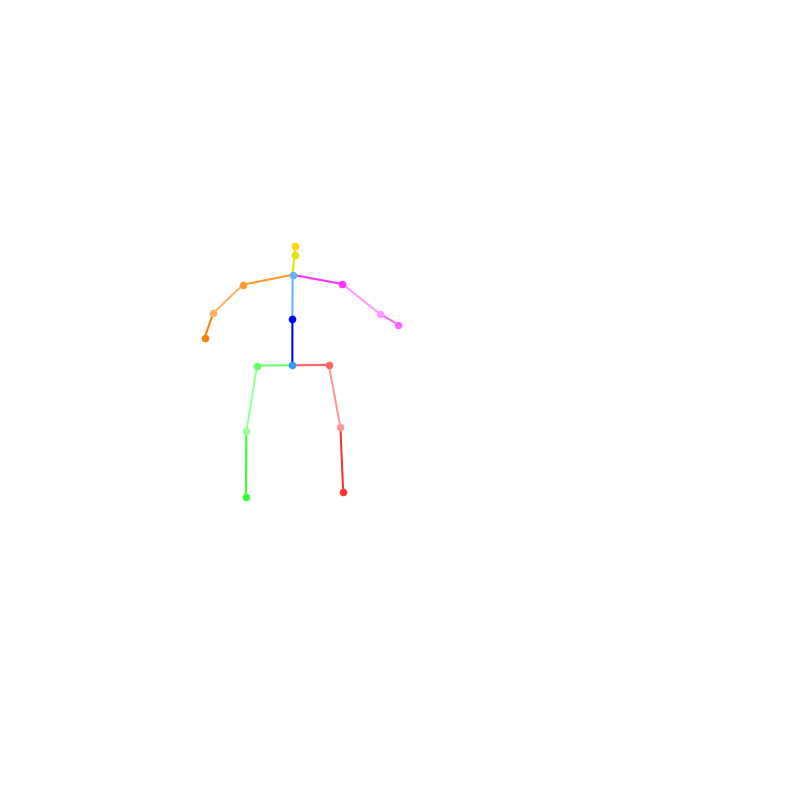

In [332]:
outputs = np.load('/Users/i590389/Desktop/papers/modality invariant/self_paper/pics/E01_S03_A20_frame275_RW.npy')
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.set_xlim3d([0, 1.3])
ax.set_zlim3d([0, 2])
ax.set_ylim3d([0, 1.5])
ax.view_init(elev=5, azim = 85)
idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
for id in idx:
    ax.scatter(1-outputs[0][id][0], outputs[0][id][2]-3, 1-outputs[0][id][1], c = (pose_kpt_color[id][0],pose_kpt_color[id][1],pose_kpt_color[id][2]))
for i, line in enumerate(skeleton):
    start_idx = line[0]
    end_idx = line[1]
    ax.plot([1-outputs[0][start_idx][0], 1-outputs[0][end_idx][0]],[outputs[0][start_idx][2]-3,outputs[0][end_idx][2]-3],zs=[1-outputs[0][start_idx][1],1-outputs[0][end_idx][1]],c = (pose_kpt_color[end_idx][0],pose_kpt_color[end_idx][1],pose_kpt_color[end_idx][2]))
plt.axis('off')
plt.show()

# 4

/var/folders/zy/5ffpky1j2j31qd6wrlpb02bc0000gn/T/ipykernel_27926/231842969.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(1-outputs[0][id][0], outputs[0][id][2]-3, 1-outputs[0][id][1], c = (pose_kpt_color[id][0],pose_kpt_color[id][1],pose_kpt_color[id][2]))


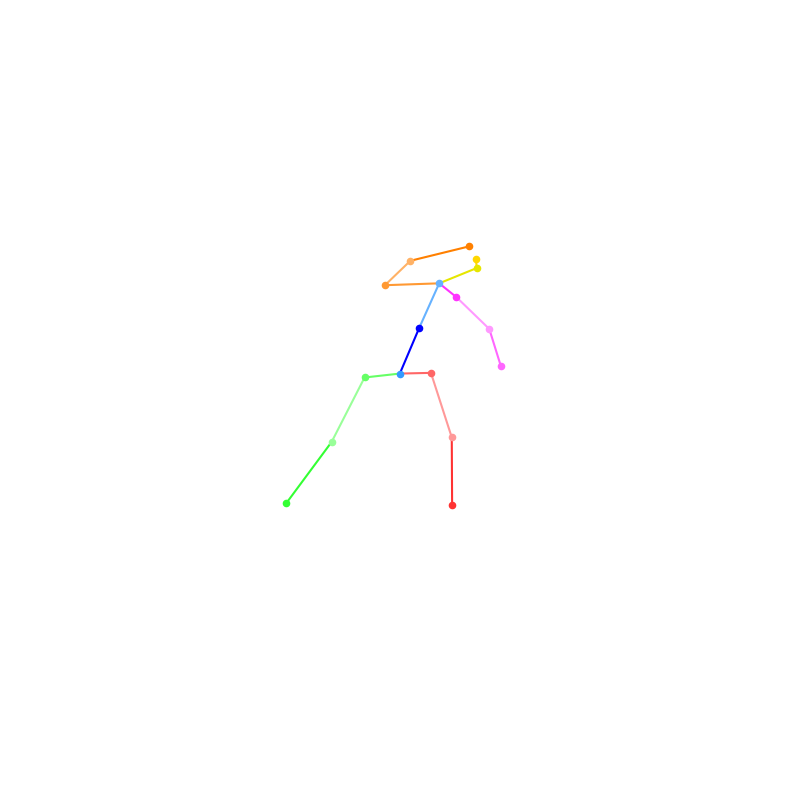

In [333]:
outputs = np.load('/Users/i590389/Desktop/papers/modality invariant/self_paper/pics/E01_S03_A20_frame275_norgb.npy')
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.set_xlim3d([0, 1.3])
ax.set_zlim3d([0, 2])
ax.set_ylim3d([0, 1.5])
ax.view_init(elev=5, azim = 85)
idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
for id in idx:
    ax.scatter(1-outputs[0][id][0], outputs[0][id][2]-3, 1-outputs[0][id][1], c = (pose_kpt_color[id][0],pose_kpt_color[id][1],pose_kpt_color[id][2]))
for i, line in enumerate(skeleton):
    start_idx = line[0]
    end_idx = line[1]
    ax.plot([1-outputs[0][start_idx][0], 1-outputs[0][end_idx][0]],[outputs[0][start_idx][2]-3,outputs[0][end_idx][2]-3],zs=[1-outputs[0][start_idx][1],1-outputs[0][end_idx][1]],c = (pose_kpt_color[end_idx][0],pose_kpt_color[end_idx][1],pose_kpt_color[end_idx][2]))
plt.axis('off')
plt.show()

/var/folders/zy/5ffpky1j2j31qd6wrlpb02bc0000gn/T/ipykernel_27926/1438836753.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(1-outputs[0][id][0], outputs[0][id][2]-3, 1-outputs[0][id][1], c = (pose_kpt_color[id][0],pose_kpt_color[id][1],pose_kpt_color[id][2]))


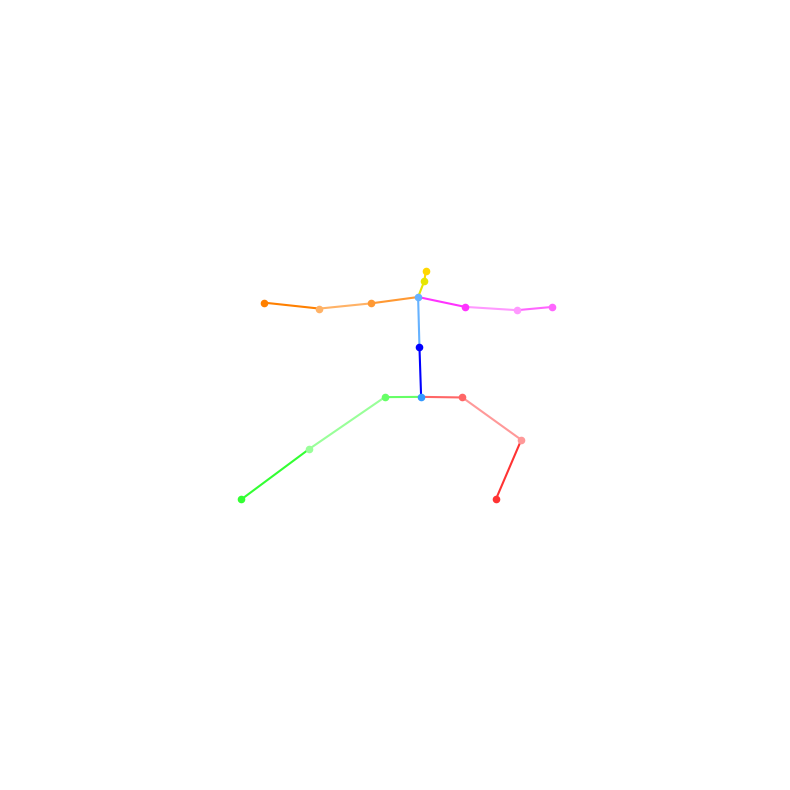

In [334]:
outputs = np.load('/Users/i590389/Desktop/papers/modality invariant/self_paper/pics/E01_S03_A20_frame275_nodepth.npy')
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.set_xlim3d([0, 1.3])
ax.set_zlim3d([0, 2])
ax.set_ylim3d([0, 1.5])
ax.view_init(elev=5, azim = 85)
idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
for id in idx:
    ax.scatter(1-outputs[0][id][0], outputs[0][id][2]-3, 1-outputs[0][id][1], c = (pose_kpt_color[id][0],pose_kpt_color[id][1],pose_kpt_color[id][2]))
for i, line in enumerate(skeleton):
    start_idx = line[0]
    end_idx = line[1]
    ax.plot([1-outputs[0][start_idx][0], 1-outputs[0][end_idx][0]],[outputs[0][start_idx][2]-3,outputs[0][end_idx][2]-3],zs=[1-outputs[0][start_idx][1],1-outputs[0][end_idx][1]],c = (pose_kpt_color[end_idx][0],pose_kpt_color[end_idx][1],pose_kpt_color[end_idx][2]))
plt.axis('off')
plt.show()

/var/folders/zy/5ffpky1j2j31qd6wrlpb02bc0000gn/T/ipykernel_27926/704902686.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(1-outputs[0][id][0], outputs[0][id][2]-3, 1-outputs[0][id][1], c = (pose_kpt_color[id][0],pose_kpt_color[id][1],pose_kpt_color[id][2]))


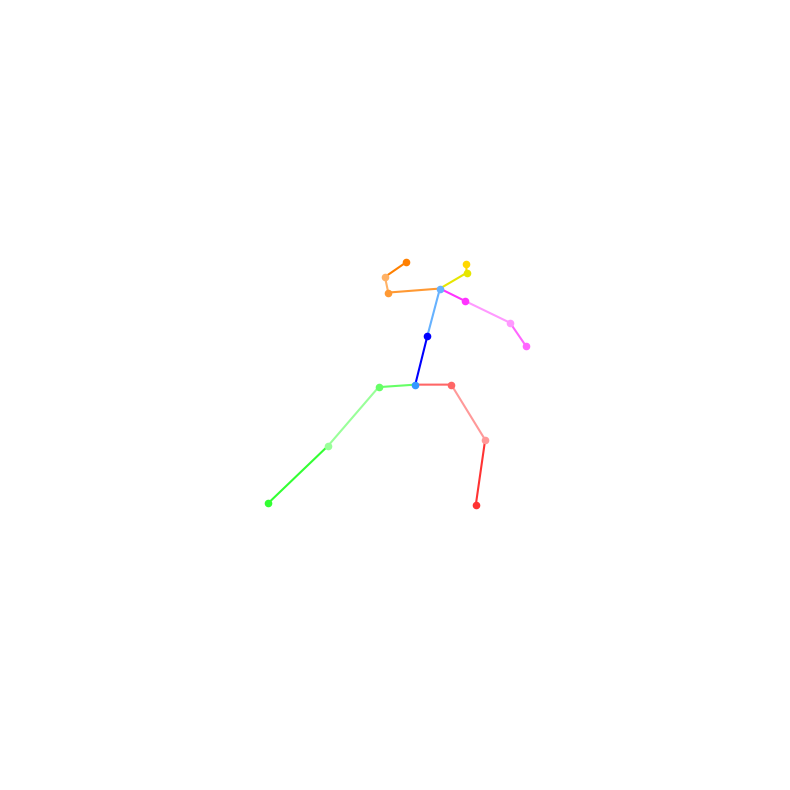

In [335]:
outputs = np.load('/Users/i590389/Desktop/papers/modality invariant/self_paper/pics/E01_S03_A20_frame275_nommwave.npy')
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.set_xlim3d([0, 1.3])
ax.set_zlim3d([0, 2])
ax.set_ylim3d([0, 1.5])
ax.view_init(elev=5, azim = 85)
idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
for id in idx:
    ax.scatter(1-outputs[0][id][0], outputs[0][id][2]-3, 1-outputs[0][id][1], c = (pose_kpt_color[id][0],pose_kpt_color[id][1],pose_kpt_color[id][2]))
for i, line in enumerate(skeleton):
    start_idx = line[0]
    end_idx = line[1]
    ax.plot([1-outputs[0][start_idx][0], 1-outputs[0][end_idx][0]],[outputs[0][start_idx][2]-3,outputs[0][end_idx][2]-3],zs=[1-outputs[0][start_idx][1],1-outputs[0][end_idx][1]],c = (pose_kpt_color[end_idx][0],pose_kpt_color[end_idx][1],pose_kpt_color[end_idx][2]))
plt.axis('off')
plt.show()

/var/folders/zy/5ffpky1j2j31qd6wrlpb02bc0000gn/T/ipykernel_27926/2355423620.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(1-outputs[0][id][0], outputs[0][id][2]-3, 1-outputs[0][id][1], c = (pose_kpt_color[id][0],pose_kpt_color[id][1],pose_kpt_color[id][2]))


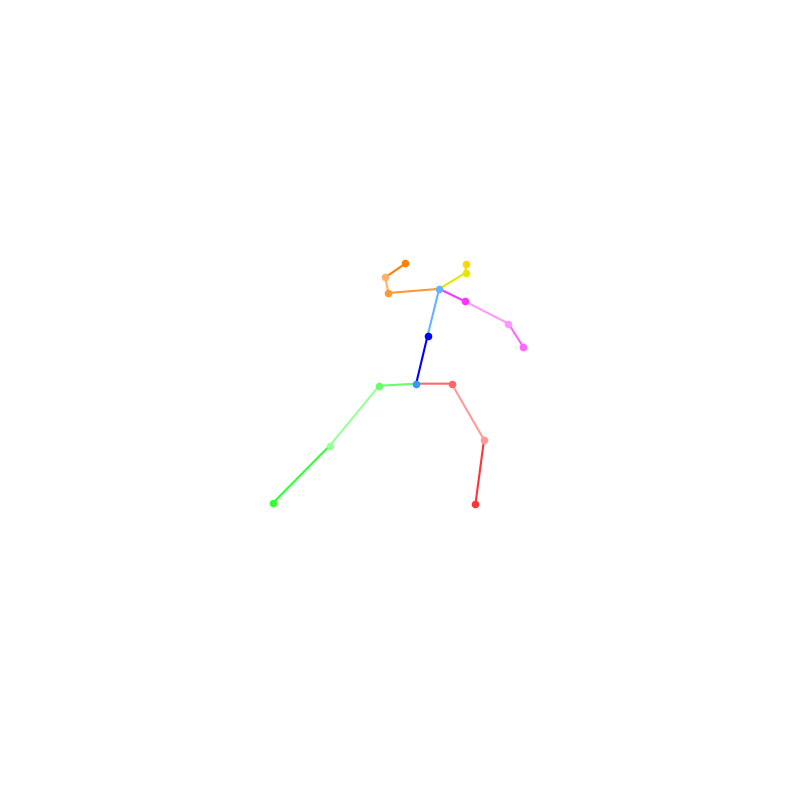

In [336]:
outputs = np.load('/Users/i590389/Desktop/papers/modality invariant/self_paper/pics/E01_S03_A20_frame275_nolidar.npy')
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.set_xlim3d([0, 1.3])
ax.set_zlim3d([0, 2])
ax.set_ylim3d([0, 1.5])
ax.view_init(elev=5, azim = 85)
idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
for id in idx:
    ax.scatter(1-outputs[0][id][0], outputs[0][id][2]-3, 1-outputs[0][id][1], c = (pose_kpt_color[id][0],pose_kpt_color[id][1],pose_kpt_color[id][2]))
for i, line in enumerate(skeleton):
    start_idx = line[0]
    end_idx = line[1]
    ax.plot([1-outputs[0][start_idx][0], 1-outputs[0][end_idx][0]],[outputs[0][start_idx][2]-3,outputs[0][end_idx][2]-3],zs=[1-outputs[0][start_idx][1],1-outputs[0][end_idx][1]],c = (pose_kpt_color[end_idx][0],pose_kpt_color[end_idx][1],pose_kpt_color[end_idx][2]))
plt.axis('off')
plt.show()

/var/folders/zy/5ffpky1j2j31qd6wrlpb02bc0000gn/T/ipykernel_27926/1024818766.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(1-outputs[0][id][0], outputs[0][id][2]-3, 1-outputs[0][id][1], c = (pose_kpt_color[id][0],pose_kpt_color[id][1],pose_kpt_color[id][2]))


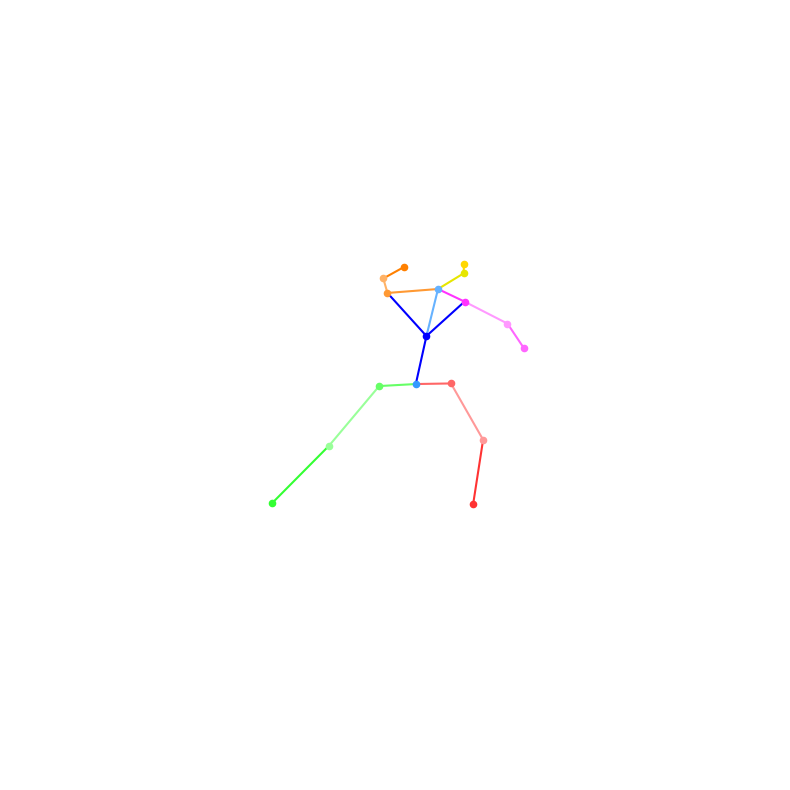

In [342]:

outputs = np.load('/Users/i590389/Desktop/papers/modality invariant/self_paper/pics/E01_S03_A20_frame275_nowifi.npy')
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.set_xlim3d([0, 1.3])
ax.set_zlim3d([0, 2])
ax.set_ylim3d([0, 1.5])
ax.view_init(elev=5, azim = 85)
idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
for id in idx:
    ax.scatter(1-outputs[0][id][0], outputs[0][id][2]-3, 1-outputs[0][id][1], c = (pose_kpt_color[id][0],pose_kpt_color[id][1],pose_kpt_color[id][2]))
for i, line in enumerate(skeleton):
    start_idx = line[0]
    end_idx = line[1]
    ax.plot([1-outputs[0][start_idx][0], 1-outputs[0][end_idx][0]],[outputs[0][start_idx][2]-3,outputs[0][end_idx][2]-3],zs=[1-outputs[0][start_idx][1],1-outputs[0][end_idx][1]],c = (pose_kpt_color[end_idx][0],pose_kpt_color[end_idx][1],pose_kpt_color[end_idx][2]))
plt.axis('off')
plt.show()

/var/folders/zy/5ffpky1j2j31qd6wrlpb02bc0000gn/T/ipykernel_27926/1647074332.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(1-outputs[0][id][0], outputs[0][id][2]-3, 1-outputs[0][id][1], c = (pose_kpt_color[id][0],pose_kpt_color[id][1],pose_kpt_color[id][2]))


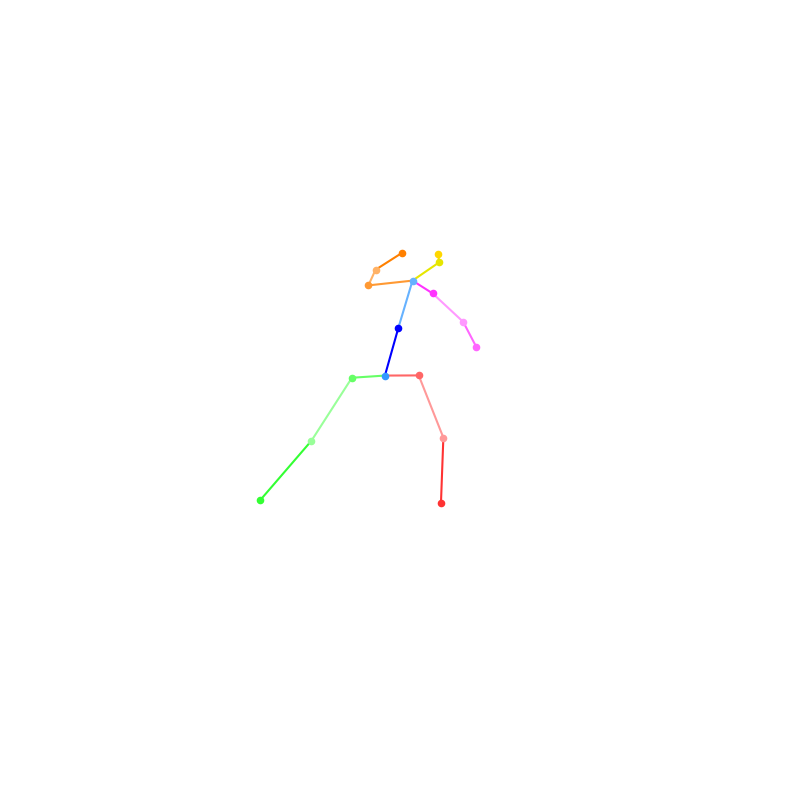

In [338]:

outputs = np.load('/Users/i590389/Desktop/papers/modality invariant/self_paper/pics/E01_S03_A20_frame010_all.npy')
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.set_xlim3d([0, 1.3])
ax.set_zlim3d([0, 2])
ax.set_ylim3d([0, 1.5])
ax.view_init(elev=5, azim = 85)
idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
for id in idx:
    ax.scatter(1-outputs[0][id][0], outputs[0][id][2]-3, 1-outputs[0][id][1], c = (pose_kpt_color[id][0],pose_kpt_color[id][1],pose_kpt_color[id][2]))
for i, line in enumerate(skeleton):
    start_idx = line[0]
    end_idx = line[1]
    ax.plot([1-outputs[0][start_idx][0], 1-outputs[0][end_idx][0]],[outputs[0][start_idx][2]-3,outputs[0][end_idx][2]-3],zs=[1-outputs[0][start_idx][1],1-outputs[0][end_idx][1]],c = (pose_kpt_color[end_idx][0],pose_kpt_color[end_idx][1],pose_kpt_color[end_idx][2]))
plt.axis('off')
plt.show()

/var/folders/zy/5ffpky1j2j31qd6wrlpb02bc0000gn/T/ipykernel_27926/3888922744.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(1-outputs[0][id][0], outputs[0][id][2]-3, 1-outputs[0][id][1], c = (pose_kpt_color[id][0],pose_kpt_color[id][1],pose_kpt_color[id][2]))


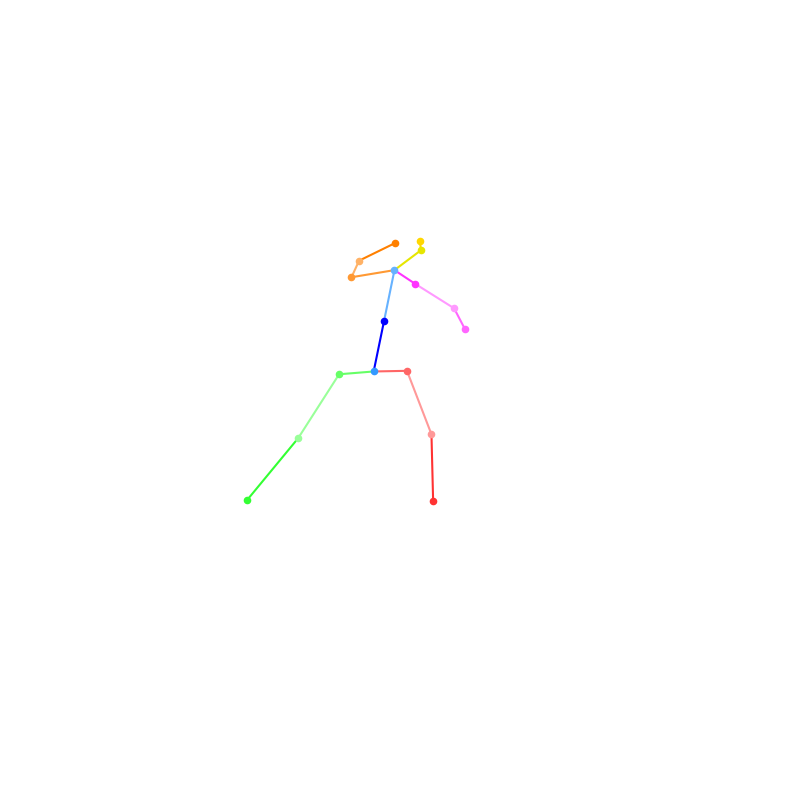

In [339]:
outputs = np.load('/Users/i590389/Desktop/papers/modality invariant/self_paper/pics/E01_S03_A20_frame144_all.npy')
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.set_xlim3d([0, 1.3])
ax.set_zlim3d([0, 2])
ax.set_ylim3d([0, 1.5])
ax.view_init(elev=5, azim = 85)
idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
for id in idx:
    ax.scatter(1-outputs[0][id][0], outputs[0][id][2]-3, 1-outputs[0][id][1], c = (pose_kpt_color[id][0],pose_kpt_color[id][1],pose_kpt_color[id][2]))
for i, line in enumerate(skeleton):
    start_idx = line[0]
    end_idx = line[1]
    ax.plot([1-outputs[0][start_idx][0], 1-outputs[0][end_idx][0]],[outputs[0][start_idx][2]-3,outputs[0][end_idx][2]-3],zs=[1-outputs[0][start_idx][1],1-outputs[0][end_idx][1]],c = (pose_kpt_color[end_idx][0],pose_kpt_color[end_idx][1],pose_kpt_color[end_idx][2]))
plt.axis('off')
plt.show()